In [ ]:
!pip install scikit-learn==1.7.2
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import splrep, splev
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
from catboost import CatBoostClassifier

import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import optuna
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.set_printoptions(legacy='1.25')

# Uploading Data


In [ ]:
from google.colab import files

data = pd.read_pickle("Xtrain2.pkl")
Y = np.load("Ytrain2.npy")

In [ ]:
data.head()

Patient_Id Exercise_Id                                  Skeleton_Sequence
0           1          E1  [[-0.006559493, -0.596473992, 0.008439806, -0....
1           1          E1  [[-0.013246231, -0.53470093, 0.001707567, -0.5...
2           1          E1  [[0.01791355, -0.56308651, 0.03354283, -0.5888...
3           2          E1  [[-0.002102487, -0.598189116, 0.014012374, -0....
4           3          E1  [[0.019835064, -0.562546909, 0.037609391, -0.5...

In [ ]:
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())


Data shape: (444, 3)
Columns: ['Patient_Id', 'Exercise_Id', 'Skeleton_Sequence']


In [ ]:
shape = data["Skeleton_Sequence"].apply(lambda x: x.shape)
print(data[["Patient_Id", "Exercise_Id"]].assign(seq_shape=shape).head())
print(min(shape))
print(max(shape))


   Patient_Id Exercise_Id  seq_shape
0           1          E1  (172, 66)
1           1          E1  (133, 66)
2           1          E1  (130, 66)
3           2          E1  (103, 66)
4           3          E1  (123, 66)
(50, 66)
(622, 66)


In [ ]:
print(Y) # left -> 0, right -> 1

[0 0 0 0 1 1 1 0 0 0 0 1 0 1]


In [ ]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 9, 1: 5}


In [ ]:
patients = data['Patient_Id'].values
exercises = data['Exercise_Id'].values

print(data['Exercise_Id'].value_counts())
print(patients)

Exercise_Id
E4    115
E5    113
E3    111
E2     54
E1     51
Name: count, dtype: int64
[ 1  1  1  2  3  3  3  3  4  5  5  5  5  6  6  6  6  6  6  6  7  7  7  8
  8  8  8  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 13 13 13 13 13 14
 14 14 14  1  1  1  1  2  3  3  3  3  3  4  4  4  4  5  5  6  6  6  6  6
  6  6  7  7  7  7  7  7  8  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11
 11 11 11 12 13 13 13 14 14  1  1  1  1  1  2  2  2  2  2  2  2  2  2  3
  3  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5  5  5  5  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9
  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 12 12
 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  6  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  9  9
  9  9  9  9  9  9 10 10 10 10 10 10

In [ ]:
# Observing recordings

idx = 3
seq = np.array(data.iloc[idx]['Skeleton_Sequence'], dtype=float).reshape(-1, 33, 2)

mp_connections = [
    (11, 13), (13, 15),      # left arm
    (12, 14), (14, 16),      # right arm
    (11, 12),                # shoulders
    (23, 24),                # hips
    (11, 23), (12, 24),      # torso
    (23, 25), (25, 27),      # left leg
    (24, 26), (26, 28),      # right leg
    (27, 29), (29, 31),      # left foot
    (28, 30), (30, 32)       # right foot
]

left_side = [11, 13, 15, 23, 25, 27, 29, 31]
right_side = [12, 14, 16, 24, 26, 28, 30, 32]

affected_side = Y[data.iloc[idx]['Patient_Id'] - 1]
print(affected_side)
affected_side = 'L' if affected_side == 0 else 'R'

if affected_side == 'L':
    affected_indices = left_side
    healthy_indices = right_side
else:
    affected_indices = right_side
    healthy_indices = left_side

affected_color = 'red'
healthy_color = 'green'
nose_color = 'blue'

# Setup figure
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title(f"Patient {data.iloc[idx]['Patient_Id']} - Exercise {data.iloc[idx]['Exercise_Id']}, Affected side {affected_side}")

# Separate point plots
points_affected, = ax.plot([], [], 'o', color=affected_color, label='Affected')
points_healthy, = ax.plot([], [], 'o', color=healthy_color, label='Healthy')
point_nose, = ax.plot([], [], 'o', color=nose_color, label='Nose', markersize=6)  # single point (safe)
lines = [ax.plot([], [], 'k-', lw=1)[0] for _ in mp_connections]

ax.legend()

def init():
    points_affected.set_data([], [])
    points_healthy.set_data([], [])
    point_nose.set_data([], [])
    for ln in lines:
        ln.set_data([], [])
    return [points_affected, points_healthy, point_nose] + lines

def update(frame):
    keypoints = seq[frame]
    points_affected.set_data(keypoints[affected_indices, 0], keypoints[affected_indices, 1])
    points_healthy.set_data(keypoints[healthy_indices, 0], keypoints[healthy_indices, 1])
    point_nose.set_data([keypoints[0, 0]], [keypoints[0, 1]])

    for i, (a, b) in enumerate(mp_connections):
        lines[i].set_data([keypoints[a, 0], keypoints[b, 0]],
                          [keypoints[a, 1], keypoints[b, 1]])
    return [points_affected, points_healthy, point_nose] + lines

ani = animation.FuncAnimation(fig, update, frames=len(seq),
                              init_func=init, interval=50, blit=False, repeat=True)

plt.close(fig)
HTML(ani.to_jshtml())


0


In [ ]:
# Checks if an observation is faulty (barely no movement)
def std_sum(seq):
  n = seq.shape[0]
  seq = seq.reshape(n, 33, 2).copy()

  StdX = seq[:, :, 0].std(axis=0)
  StdY = seq[:, :, 1].std(axis=0)

  return StdX.sum() + StdY.sum()

In [ ]:
for i in range(444):
  seq = data["Skeleton_Sequence"].iloc[i]
  if std_sum(seq) < 1:
    print(std_sum(seq), i)

0.9672946925514314 17
0.6977876111015735 18
0.7515613165248203 35
0.5949653306815473 50
0.8943056323135388 94
0.796124644714389 95
0.6454310258364219 97
0.8792181955423053 98


In [ ]:
# Normalizes data according to torso and shoulder length ratio
def Normalize(seq):
  n = seq.shape[0]
  X = seq.reshape(n, 33, 2).copy()

  X[:, :, 1] *= -1 # correct the sign of the y coordinates

  sw = np.linalg.norm(X[:, 11, :] - X[:, 12, :], axis=1) # shoulder width
  th = np.linalg.norm(X[:, 0, :] - 0.5 * (X[:, 23, :] + X[:, 24, :]), axis=1) # torso height

  scale = sw / th
  X = X / scale[:, None, None]
  X = X.reshape(n, -1)
  return X

data_normalized = data.copy()
data_normalized['Skeleton_Sequence'] = data['Skeleton_Sequence'].apply(lambda seq: Normalize(np.array(seq)))


In [ ]:
# Interpolates a skeleton sequence to a fixed number of frames using cubic splines
def CubicSplines(seq, n):
  # n is the lenght of the new sequences
    T = seq.shape[0]
    old_t = np.linspace(0, 1, T)
    new_t = np.linspace(0, 1, n)

    interp = np.zeros((n, seq.shape[1], seq.shape[2]))

    for j in range(seq.shape[1]):  # joints
        for k in range(seq.shape[2]):  # x and y
            tck = splrep(old_t, seq[:, j, k], s = 0)
            interp[:, j, k] = splev(new_t, tck)

    return interp

# Applies interpolation to the whole data
def InterpolData(data, n):
    data = data.copy()
    data['Skeleton_Sequence'] = data['Skeleton_Sequence'].apply(lambda x: CubicSplines(np.array(x).reshape(-1, 33, 2), n))
    return data


In [ ]:
X_interp = InterpolData(data_normalized, 100)
X_interp["Skeleton_Sequence"].iloc[0].shape
print(X_interp["Skeleton_Sequence"].iloc[3])

[[[-3.68833013e-03  1.04938529e+00]
  [ 2.45814890e-02  1.08513850e+00]
  [ 3.08387039e-02  1.08387737e+00]
  ...
  [-2.86280922e-01 -1.06307955e+00]
  [ 2.09959142e-01 -1.21656570e+00]
  [-3.16746661e-01 -1.09873029e+00]]

 [[ 1.05815323e-03  1.04970895e+00]
  [ 3.03470972e-02  1.08629116e+00]
  [ 3.70979594e-02  1.08502283e+00]
  ...
  [-2.82940329e-01 -1.05847375e+00]
  [ 2.04564135e-01 -1.21071011e+00]
  [-3.14353440e-01 -1.08657028e+00]]

 [[-8.54560188e-03  1.01654084e+00]
  [ 2.24279904e-02  1.05283004e+00]
  [ 2.90391295e-02  1.05141605e+00]
  ...
  [-2.71972534e-01 -1.02951099e+00]
  [ 1.88958185e-01 -1.17103074e+00]
  [-3.05809075e-01 -1.05424231e+00]]

 ...

 [[ 1.73413523e-02  1.07410963e+00]
  [ 5.28099178e-02  1.11107104e+00]
  [ 5.91730601e-02  1.10928833e+00]
  ...
  [-2.97836799e-01 -1.06871150e+00]
  [ 2.33933748e-01 -1.23210891e+00]
  [-3.18739229e-01 -1.10558450e+00]]

 [[ 2.58181597e-02  1.05165470e+00]
  [ 6.13560244e-02  1.08779752e+00]
  [ 6.76240088e-02  1.0862

# Coordinate features
5 positions equally spaced in the whole movement
- E1 and E2: wrist and elbow from the moving side and both shoulders
- E3: wrists, elbows and shoulders
- E4: elbows, shoulders
- E5: knees, shoulders, wrists

In [ ]:
def SaySide(df):
  n = df.shape[0]
  Sides = np.ones(n)

  for i in range(n):
      seq = np.array(df.iloc[i]['Skeleton_Sequence'])
      m = seq.shape[0]
      seq = seq.reshape(m, 33, 2)

      Std = seq.std(axis=0)
      if np.linalg.norm(Std[12::2, :]) > np.linalg.norm(Std[11::2, :]):
        Sides[i] = -1

  return Sides

  def Std(df, joints):
    n = df.shape[0]
    m = len(joints)
    Std = np.zeros((n, m))

    for i in range(n):
      seq = np.array(df.iloc[i]['Skeleton_Sequence'])
      seq = seq.reshape(seq.shape[0], 33, 2)

      for j in range(m):
        Std[i, j] = np.linalg.norm(seq[:, joints[j], :].std(axis=0))

  return Std

In [ ]:
X_interp_5 = InterpolData(data_normalized, 5)

# Flipping the x coords of samples of two pacients impaired on the left side in order to have a balanced dataset
ids = [2, 8]

for i, row in X_interp_5.iterrows():
    if row["Patient_Id"] in ids:
        seq = np.array(row["Skeleton_Sequence"], dtype=float)
        seq[:, :, 0] = -seq[:, :, 0]
        X_interp_5.at[i, "Skeleton_Sequence"] = seq

for i in ids:
    Y[i - 1] = 1

print(Y)
print(X_interp_5["Skeleton_Sequence"].iloc[3])

[0 1 0 0 1 1 1 1 0 0 0 1 0 1]
[[[ 3.68833013e-03  1.04938529e+00]
  [-2.45814890e-02  1.08513850e+00]
  [-3.08387039e-02  1.08387737e+00]
  [-2.44634635e-02  1.08169275e+00]
  [ 1.75365700e-02  1.08980618e+00]
  [ 9.96828911e-03  1.08728444e+00]
  [ 2.02398915e-03  1.07401910e+00]
  [-1.41228023e-01  1.02975784e+00]
  [ 9.98476101e-02  9.60464485e-01]
  [-5.99981117e-02  1.01783790e+00]
  [-2.72197464e-03  9.57581275e-01]
  [-3.35957459e-01  8.01929057e-01]
  [ 2.60588755e-01  7.99492485e-01]
  [-5.62957451e-01  9.19757829e-01]
  [ 3.71490462e-01  3.19270568e-01]
  [-3.23212030e-01  1.03024081e+00]
  [ 3.03887599e-01  8.37941860e-02]
  [-2.46261661e-01  1.04529888e+00]
  [ 2.14848035e-01  3.52825017e-02]
  [-1.82507645e-01  1.07649086e+00]
  [ 1.33135842e-01  1.15579708e-01]
  [-2.92903084e-01  1.01011167e+00]
  [ 2.56985762e-01  9.25958714e-02]
  [-1.75372275e-01  9.38773096e-04]
  [ 1.73120912e-01  4.83010034e-03]
  [-2.54425808e-01 -3.06701510e-01]
  [ 1.47339148e-01 -1.76976333e-01

In [ ]:
def ActiveSide(seq):
  std_left_wrist = seq[:, 15, 0].std(axis=0) + seq[:, 15, 1].std(axis=0)
  std_right_wrist = seq[:, 16, 0].std(axis=0) + seq[:, 16, 1].std(axis=0)
  std_left_elbow = seq[:, 13, 0].std(axis=0) + seq[:, 13, 1].std(axis=0)
  std_right_elbow = seq[:, 14, 0].std(axis=0) + seq[:, 14, 1].std(axis=0)

  if std_left_wrist + std_left_elbow > std_right_wrist + std_right_elbow:
    return [11, 12, 15, 13]
  else:
    return [11, 12, 16, 14]

def KeepPoints(seq, joints):
  return seq[:, joints, :]

exercise_types = X_interp_5['Exercise_Id'].unique()
exercise_dfs = {ex: X_interp_5[X_interp_5['Exercise_Id'] == ex] for ex in exercise_types}

# E1 and E2
E12_pos = pd.concat([exercise_dfs['E1'], exercise_dfs['E2']], ignore_index=True)

PosListE12 = []
for i, seq in E12_pos.iterrows():
  feats = KeepPoints(seq['Skeleton_Sequence'], ActiveSide(seq['Skeleton_Sequence']))
  PosListE12.append(feats)

X_E12_pos = np.array(PosListE12)
X_E12_pos_flat = X_E12_pos.reshape(X_E12_pos.shape[0], -1)
#X_E12_pos_flat = np.hstack((X_E12_pos_flat, SaySide(E12_pos).reshape(-1, 1)))
print(X_E12_pos_flat.shape)

patients_E12_pos = E12_pos['Patient_Id'].values
y_E12_pos = np.array([Y[p-1] for p in patients_E12_pos])

# Exercise 3
E3_pos = exercise_dfs['E3']

joints_E3 = [11, 12, 13, 14, 15, 16]

PosListE3 = []
for i, seq in E3_pos.iterrows():
  feats = KeepPoints(seq['Skeleton_Sequence'], joints_E3)
  PosListE3.append(feats)

X_E3_pos = np.array(PosListE3)
X_E3_pos_flat = X_E3_pos.reshape(X_E3_pos.shape[0], -1)
X_E3_pos_flat = np.hstack((X_E3_pos_flat, SaySide(E3_pos).reshape(-1, 1)))
#X_E3_pos_flat = np.hstack((X_E3_pos_flat, Std(E3_pos, [15, 16])))
print(X_E3_pos_flat.shape)

patients_E3_pos = E3_pos['Patient_Id'].values
y_E3_pos = np.array([Y[p-1] for p in patients_E3_pos])

# Exercise 4
E4_pos = exercise_dfs['E4']

joints_E4 = [13, 14, 15, 16]

PosListE4 = []
for i, seq in E4_pos.iterrows():
  feats = KeepPoints(seq['Skeleton_Sequence'], joints_E4)
  PosListE4.append(feats)

X_E4_pos = np.array(PosListE4)
X_E4_pos_flat = X_E4_pos.reshape(X_E4_pos.shape[0], -1)
#X_E4_pos_flat = np.hstack((X_E4_pos_flat, SaySide(E4_pos).reshape(-1, 1)))
print(X_E4_pos_flat.shape)

patients_E4_pos = E4_pos['Patient_Id'].values
y_E4_pos = np.array([Y[p-1] for p in patients_E4_pos])

# Exercise 5
E5_pos = exercise_dfs['E5']

joints_E5 = [11, 12, 15, 16, 25, 26]

PosListE5 = []
for i, seq in E5_pos.iterrows():
  feats = KeepPoints(seq['Skeleton_Sequence'], joints_E5)
  PosListE5.append(feats)

X_E5_pos = np.array(PosListE5)
X_E5_pos_flat = X_E5_pos.reshape(X_E5_pos.shape[0], -1)
X_E5_pos_flat = np.hstack((X_E5_pos_flat, SaySide(E5_pos).reshape(-1, 1)))
print(X_E5_pos_flat.shape)

patients_E5_pos = E5_pos['Patient_Id'].values
y_E5_pos = np.array([Y[p-1] for p in patients_E5_pos])


(105, 40)
(111, 61)
(115, 40)
(113, 61)


In [ ]:
# GroupKFold split based on all patients
unique_patients = np.unique(np.concatenate([
    patients_E12_pos, patients_E3_pos, patients_E4_pos, patients_E5_pos]))

rng = np.random.default_rng(12234)
rng.shuffle(unique_patients)

n_splits = 14
folds = np.array_split(unique_patients, n_splits)

patient_to_fold = {p: i for i, fold_patients in enumerate(folds) for p in fold_patients}

# For each exercise, derive indices for that fold
def get_fold_indices(patients, fold_idx):
    mask = np.isin(patients, folds[fold_idx])
    val_idx = np.where(mask)[0]
    train_idx = np.where(~mask)[0]
    return train_idx, val_idx



Running exercise: E12
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 7: bal_acc=1.000, f1=1.000

E12 Summary:
Mean Balanced Accuracy: 0.571 ± 0.175
Mean Macro-F1: 0.429 ± 0.233

Running exercise: E3
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.000, f1=0.000
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.000, f1=0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 7: bal_acc=1.000, f1=1.000

E3 Summary:
Mean Balanced Accuracy: 0.429 ± 0.319
Mean Macro-F1: 0.333 ± 0.309

Running exercise: E4
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 7: bal_acc=1.000, f1=1.000

E4 Summary:
Mean Balanced Accuracy: 0.571 ± 0.175
Mean Macro-F1: 0.429 ± 0.233

Running exercise: E5
Fold 1: bal_acc=0.000, f1=0.000
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.500, f1=0.333
Fold 7: bal_acc=0.500, f1=0.333

E5 Summary:
Mean Balanced Accuracy: 0.429 ± 0.175
Mean Macro-F1: 0.286 ± 0.117

 Fold 1 after voting 


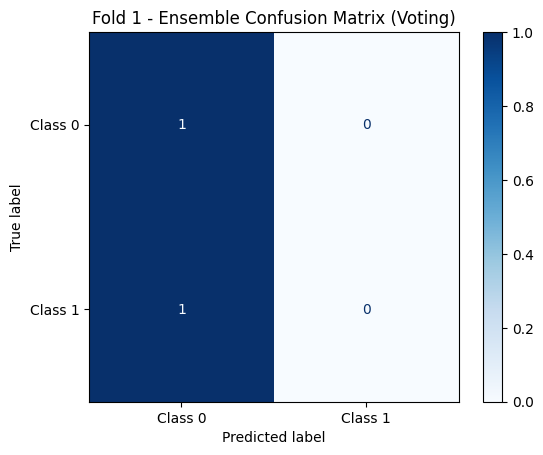

Fold 1 balanced accuracy (ensemble): 0.500

 Fold 2 after voting 


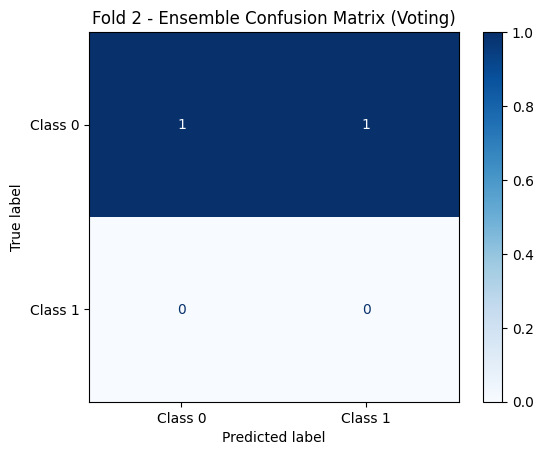

Fold 2 balanced accuracy (ensemble): 0.500

 Fold 3 after voting 


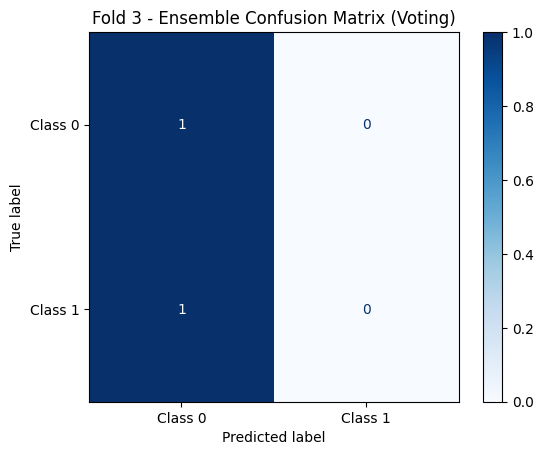

Fold 3 balanced accuracy (ensemble): 0.500

 Fold 4 after voting 


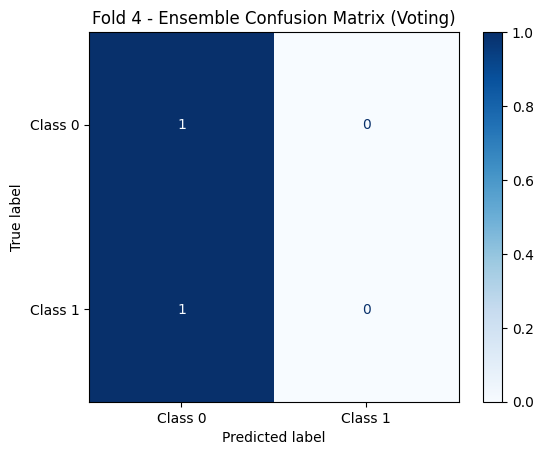

Fold 4 balanced accuracy (ensemble): 0.500

 Fold 5 after voting 


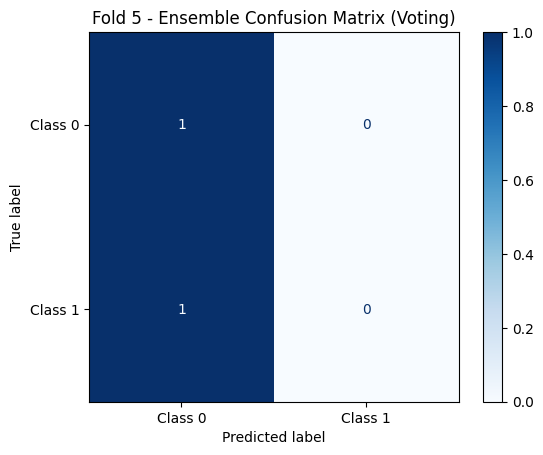

Fold 5 balanced accuracy (ensemble): 0.500

 Fold 6 after voting 


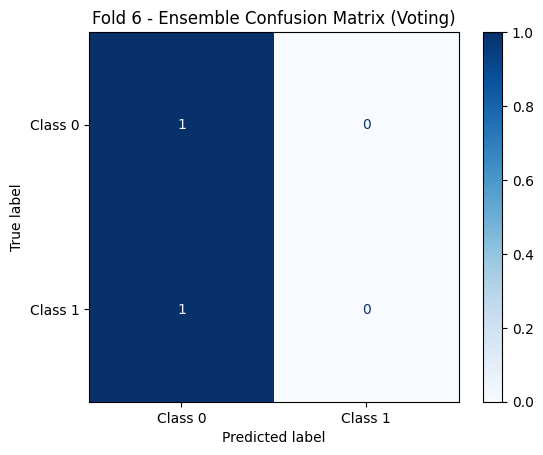

Fold 6 balanced accuracy (ensemble): 0.500

 Fold 7 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


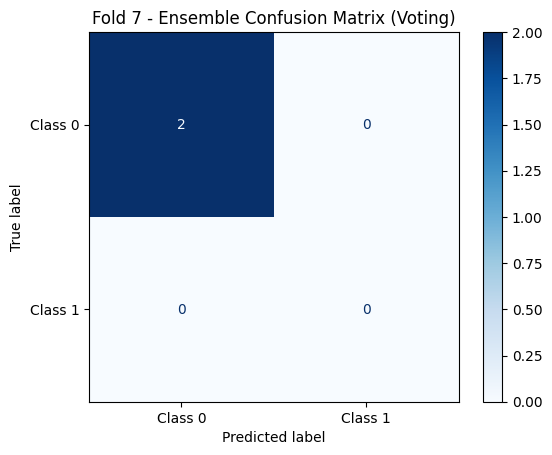

Fold 7 balanced accuracy (ensemble): 1.000

Final Ensemble Mean Balanced Accuracy: 0.571 ± 0.175


In [ ]:
# Random Forest

# Dictionary of exercises
exercises = {'E12': (X_E12_pos_flat,  patients_E12_pos,  y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

results = {}

# Loop over exercises
for ex_name, (X, patients, y) in exercises.items():
    print(f"\n{'='*30}\nRunning exercise: {ex_name}\n{'='*30}")

    model = RandomForestClassifier(n_estimators=343, random_state=42, class_weight='balanced')

    bal_acc, f1s = [], []
    fold_predictions = []

    for fold in range(n_splits):
        train_idx, val_idx = get_fold_indices(patients, fold)
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        patient_val = patients[val_idx]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Aggregate per patient
        unique_patients_val = np.unique(patient_val)
        y_true_patient = []
        y_pred_patient = []
        y_pred_patient_prob = []

        for p in unique_patients_val:
            mask = patient_val == p
            y_true_patient.append(y_val[mask][0])
            mean_prob = np.mean(y_pred_proba[mask])
            y_pred_patient_prob.append(mean_prob)
            y_pred_patient.append(int(mean_prob >= 0.5))

        y_true_patient = np.array(y_true_patient)
        y_pred_patient = np.array(y_pred_patient)
        y_pred_patient_prob = np.array(y_pred_patient_prob)

        # Metrics
        acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
        f1 = f1_score(y_true_patient, y_pred_patient, average="macro")
        bal_acc.append(acc)
        f1s.append(f1)

        print(f"Fold {fold+1}: bal_acc={acc:.3f}, f1={f1:.3f}")

        # Store fold predictions
        fold_predictions.append({"fold": fold + 1,
                                 "patients": unique_patients_val,
                                 "y_true": y_true_patient,
                                 "y_pred": y_pred_patient,
                                 "y_prob": y_pred_patient_prob})

    # Store overall results for this exercise
    results[ex_name] = {"folds": fold_predictions,
                        "metrics": {"mean_bal_acc": np.mean(bal_acc),
                                    "std_bal_acc": np.std(bal_acc),
                                    "mean_f1": np.mean(f1s),
                                    "std_f1": np.std(f1s)}}

    print(f"\n{ex_name} Summary:")
    print(f"Mean Balanced Accuracy: {np.mean(bal_acc):.3f} ± {np.std(bal_acc):.3f}")
    print(f"Mean Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# Voting for final prediction
alpha = 7  # "importance" factor
exercise_names = list(results.keys())
n_splits = len(results[exercise_names[0]]["folds"])

# softmax weights
mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
exp_vals = np.exp(alpha * mean_bal_accs)
softmax_weights = exp_vals / np.sum(exp_vals)

ensemble_bal_acc = []
all_cm = []

for fold_idx in range(n_splits):
    print(f"\n Fold {fold_idx + 1} after voting ")

    # Collect predictions across exercises for this fold
    patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
    y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

    probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

    # Weighted vote (using softmax weights)
    weighted_probs = np.dot(probs_stack, softmax_weights)
    y_pred_fold = (weighted_probs >= 0.5).astype(int)

    # Compute confusion matrix & metrics
    cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
    acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
    ensemble_bal_acc.append(acc)
    all_cm.append(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    disp.ax_.set_title(f"Fold {fold_idx + 1} - Ensemble Confusion Matrix (Voting)")
    plt.show()

    print(f"Fold {fold_idx + 1} balanced accuracy (ensemble): {acc:.3f}")

print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")


In [ ]:
# Logistic Regression

exercises = {'E12': (X_E12_pos_flat, patients_E12_pos, y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

# Choose one exercise to optimize
X = X_E3_pos_flat.copy()
patients = patients_E3_pos.copy()
y = y_E3_pos.copy()
gkf = GroupKFold(n_splits=7)

def objective(trial):
    # hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    model = LogisticRegression(C=C,
                               penalty=penalty,
                               solver=solver,
                               max_iter=500,
                               class_weight='balanced',
                               random_state=42)

    bal_acc = []

    for train_idx, val_idx in gkf.split(X, y, groups=patients):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        patient_val = patients[val_idx]

        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_val)[:, 1]

        # Aggregate per patient
        unique_patients_val = np.unique(patient_val)
        y_true_patient = []
        y_pred_patient = []

        for p in unique_patients_val:
            mask = patient_val == p
            y_true_patient.append(y_val[mask][0])  # true label for that patient
            mean_prob = np.mean(y_pred_prob[mask])  # mean probability
            y_pred_patient.append(int(mean_prob >= 0.5))  # final patient decision

        y_true_patient = np.array(y_true_patient)
        y_pred_patient = np.array(y_pred_patient)

        acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
        bal_acc.append(acc)

    return np.mean(bal_acc)

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"Balanced Accuracy Score: {trial.value:.3f}")
print(f"Params: {trial.params}")


[I 2025-10-18 20:08:43,495] A new study created in memory with name: no-name-53342c6c-30be-44d7-9bf2-dee68f282dc1
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
[I 2025-10-18 20:08:44,068] Trial 0 finished with value: 0.5714285714285714 and parameters: {'C': 8.463068328416352, 'penalty': 'l2'}. Best is trial 0 with value: 0.5714285714285714.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to

Best trial:
Balanced Accuracy Score: 0.643
Params: {'C': 0.4838638828719732, 'penalty': 'l1'}



Running exercise: E12
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.000, f1=0.000
Fold 6: bal_acc=0.000, f1=0.000
Fold 7: bal_acc=0.500, f1=0.333

E12 Summary:
Mean Balanced Accuracy: 0.357 ± 0.226
Mean Macro-F1: 0.238 ± 0.151

Running exercise: E3
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 6: bal_acc=1.000, f1=1.000
Fold 7: bal_acc=1.000, f1=1.000

E3 Summary:
Mean Balanced Accuracy: 0.714 ± 0.247
Mean Macro-F1: 0.619 ± 0.330

Running exercise: E4
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 5: bal_acc=0.000, f1=0.000
Fold 6: bal_acc=0.500, f1=0.333
Fold 7: bal_acc=0.000, f1=0.000

E4 Summary:
Mean Balanced Accuracy: 0.429 ± 0.319
Mean Macro-F1: 0.333 ± 0.309

Running exercise: E5
Fold 1: bal_acc=0.000, f1=0.000
Fold 2: bal_acc=0.000, f1=0.000
Fold 3: bal_acc=0.000, f1=0.000
Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.500, f1=0.333
Fold 7: bal_acc=0.500, f1=0.333

E5 Summary:
Mean Balanced Accuracy: 0.429 ± 0.416
Mean Macro-F1: 0.381 ± 0.415

 Fold 1 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


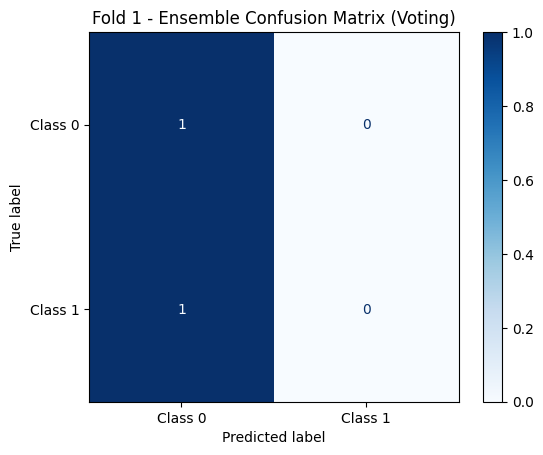

Fold 1 balanced accuracy (ensemble): 0.500

 Fold 2 after voting 


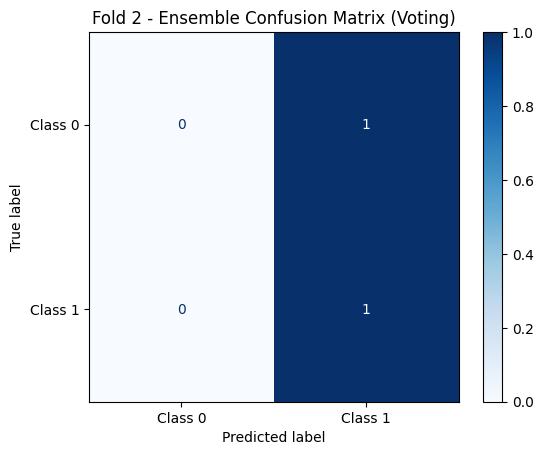

Fold 2 balanced accuracy (ensemble): 0.500

 Fold 3 after voting 


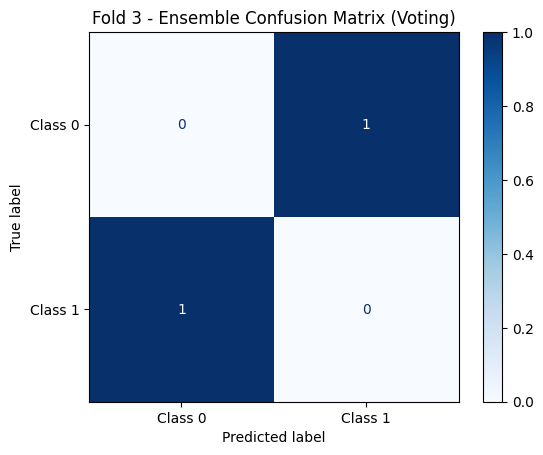

Fold 3 balanced accuracy (ensemble): 0.000

 Fold 4 after voting 


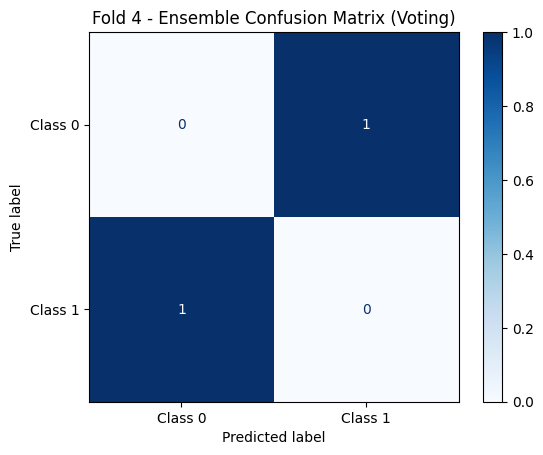

Fold 4 balanced accuracy (ensemble): 0.000

 Fold 5 after voting 


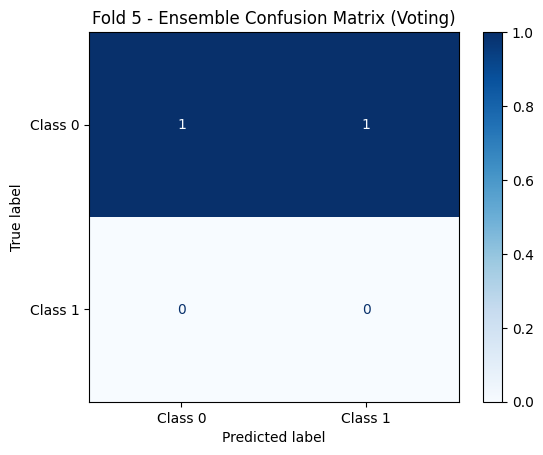

Fold 5 balanced accuracy (ensemble): 0.500

 Fold 6 after voting 


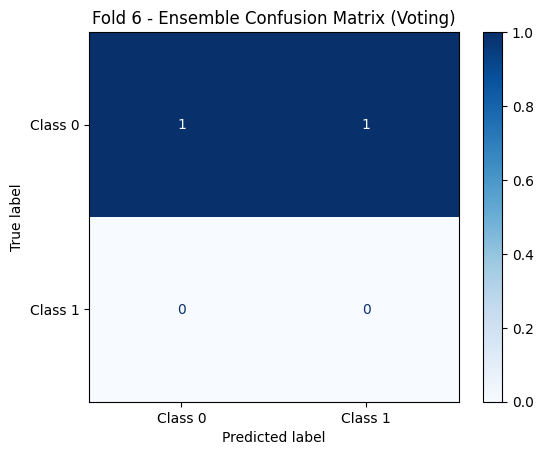

Fold 6 balanced accuracy (ensemble): 0.500

 Fold 7 after voting 


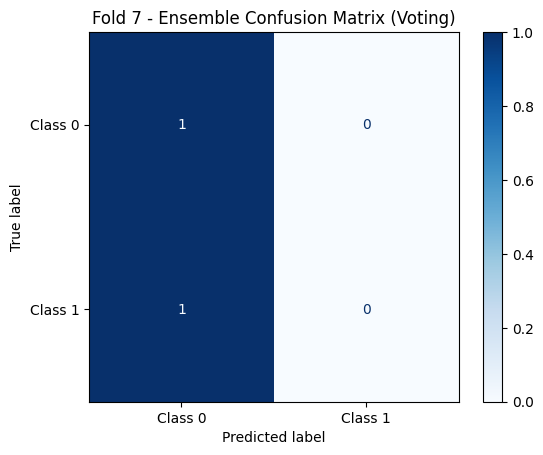

Fold 7 balanced accuracy (ensemble): 0.500

Final Ensemble Mean Balanced Accuracy: 0.357 ± 0.226


In [ ]:
# Logistic Regression

exercises = {'E12': (X_E12_pos_flat,  patients_E12_pos,  y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

results = {}
C = [0.0017470349135216378, 0.3518656652664425, 8.627832287135453, 1.0162524571573777]
i = 0
# Loop over exercises
for ex_name, (X, patients, y) in exercises.items():
    print(f"\n{'='*30}\nRunning exercise: {ex_name}\n{'='*30}")

    gkf = GroupKFold(n_splits=7)
    model = LogisticRegression(C=C[i],
                               penalty='l1',
                               solver='liblinear',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=42)
    bal_acc, f1s = [], []
    fold_predictions = []
    i  = i + 1
    # Loop over CV folds
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=patients)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        patient_val = patients[val_idx]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Aggregate per patient
        unique_patients_val = np.unique(patient_val)
        y_true_patient = []
        y_pred_patient = []
        y_pred_patient_prob = []

        for p in unique_patients_val:
            mask = patient_val == p
            y_true_patient.append(y_val[mask][0])
            mean_prob = np.mean(y_pred_proba[mask])
            y_pred_patient_prob.append(mean_prob)
            y_pred_patient.append(int(mean_prob >= 0.5))

        y_true_patient = np.array(y_true_patient)
        y_pred_patient = np.array(y_pred_patient)
        y_pred_patient_prob = np.array(y_pred_patient_prob)

        # Metrics
        acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
        f1 = f1_score(y_true_patient, y_pred_patient, average="macro")
        bal_acc.append(acc)
        f1s.append(f1)

        print(f"Fold {fold+1}: bal_acc={acc:.3f}, f1={f1:.3f}")

        # Store fold predictions
        fold_predictions.append({"fold": fold + 1,
                                 "patients": unique_patients_val,
                                 "y_true": y_true_patient,
                                 "y_pred": y_pred_patient,
                                 "y_prob": y_pred_patient_prob})

    # Store overall results for this exercise
    results[ex_name] = {"folds": fold_predictions,
                        "metrics": {"mean_bal_acc": np.mean(bal_acc),
                                    "std_bal_acc": np.std(bal_acc),
                                    "mean_f1": np.mean(f1s),
                                    "std_f1": np.std(f1s)}}

    print(f"\n{ex_name} Summary:")
    print(f"Mean Balanced Accuracy: {np.mean(bal_acc):.3f} ± {np.std(bal_acc):.3f}")
    print(f"Mean Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# Voting for final prediction
alpha = 7  # "importance" factor
exercise_names = list(results.keys())
n_splits = len(results[exercise_names[0]]["folds"])

# softmax weights
mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
exp_vals = np.exp(alpha * mean_bal_accs)
softmax_weights = exp_vals / np.sum(exp_vals)

ensemble_bal_acc = []
all_cm = []

for fold_idx in range(n_splits):
    print(f"\n Fold {fold_idx + 1} after voting ")

    # Collect predictions across exercises for this fold
    patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
    y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

    probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

    # Weighted vote (using softmax weights)
    weighted_probs = np.dot(probs_stack, softmax_weights)
    y_pred_fold = (weighted_probs >= 0.5).astype(int)

    # Compute confusion matrix & metrics
    cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
    acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
    ensemble_bal_acc.append(acc)
    all_cm.append(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    disp.ax_.set_title(f"Fold {fold_idx + 1} - Ensemble Confusion Matrix (Voting)")
    plt.show()

    print(f"Fold {fold_idx + 1} balanced accuracy (ensemble): {acc:.3f}")

print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")


In [ ]:
# finding hyperparameters for catboost

exercises = {'E12': (X_E12_pos_flat, patients_E12_pos, y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

# Choose one exercise to optimize
X = X_E3_pos_flat.copy()
patients = patients_E3_pos.copy()
y = y_E3_pos.copy()
gkf = GroupKFold(n_splits=7)

def objective(trial):
    # hyperparameters
    iterations = trial.suggest_int('iterations', 200, 2000)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 1)

    model = CatBoostClassifier(iterations=iterations,
                               depth=depth,
                               learning_rate=learning_rate,
                               l2_leaf_reg=l2_leaf_reg,
                               bagging_temperature = bagging_temperature,
                               loss_function='Logloss',
                               eval_metric='BalancedAccuracy',
                               early_stopping_rounds=50,
                               random_seed=42,
                               verbose=False)

    bal_acc = []

    for train_idx, val_idx in gkf.split(X, y, groups=patients):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        patient_val = patients[val_idx]

        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_val)[:, 1]

        # Aggregate per patient
        unique_patients_val = np.unique(patient_val)
        y_true_patient = []
        y_pred_patient = []

        for p in unique_patients_val:
            mask = patient_val == p
            y_true_patient.append(y_val[mask][0])  # true label for that patient
            mean_prob = np.mean(y_pred_prob[mask])  # mean probability
            y_pred_patient.append(int(mean_prob >= 0.5))  # final patient decision

        y_true_patient = np.array(y_true_patient)
        y_pred_patient = np.array(y_pred_patient)

        # Balanced accuracy at patient-level
        acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
        bal_acc.append(acc)

    return np.mean(bal_acc)

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print(f"Balanced Accuracy Score: {trial.value:.3f}")
print(f"Params: {trial.params}")


[I 2025-10-18 14:41:54,861] A new study created in memory with name: no-name-05b051e0-ea9d-4479-902e-f90c8d499d34
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
[I 2025-10-18 14:54:23,286] Trial 0 finished with value: 0.5714285714285714 and parameters: {'iterations': 1637, 'depth': 10, 'learning_rate': 0.07198884820293762, 'l2_leaf_reg': 4.519350684412103, 'bagging_temperature': 0.29343372075032714}. Best is trial 0 with value: 0.5714285714285714.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classi

Best trial:
Balanced Accuracy Score: 0.643
Params: {'iterations': 819, 'depth': 5, 'learning_rate': 0.03662946247859701, 'l2_leaf_reg': 5.135681998329912, 'bagging_temperature': 0.3417276741189663}



Running exercise: E12
Fold 1: bal_acc=0.500, f1=0.333
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 5: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 6: bal_acc=1.000, f1=1.000
Fold 7: bal_acc=1.000, f1=1.000

E12 Summary:
Mean Balanced Accuracy: 0.714 ± 0.247
Mean Macro-F1: 0.619 ± 0.330

Running exercise: E3


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 1: bal_acc=1.000, f1=1.000
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.000, f1=0.000
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 7: bal_acc=1.000, f1=1.000

E3 Summary:
Mean Balanced Accuracy: 0.571 ± 0.319
Mean Macro-F1: 0.476 ± 0.350

Running exercise: E4


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 1: bal_acc=1.000, f1=1.000
Fold 2: bal_acc=0.500, f1=0.333
Fold 3: bal_acc=0.500, f1=0.333
Fold 4: bal_acc=0.500, f1=0.333
Fold 5: bal_acc=0.500, f1=0.333
Fold 6: bal_acc=0.000, f1=0.000
Fold 7: bal_acc=0.000, f1=0.000

E4 Summary:
Mean Balanced Accuracy: 0.429 ± 0.319
Mean Macro-F1: 0.333 ± 0.309

Running exercise: E5
Fold 1: bal_acc=0.000, f1=0.000
Fold 2: bal_acc=0.000, f1=0.000
Fold 3: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 4: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.500, f1=0.333
Fold 7: bal_acc=0.500, f1=0.333

E5 Summary:
Mean Balanced Accuracy: 0.500 ± 0.378
Mean Macro-F1: 0.429 ± 0.387

 Fold 1 after voting 


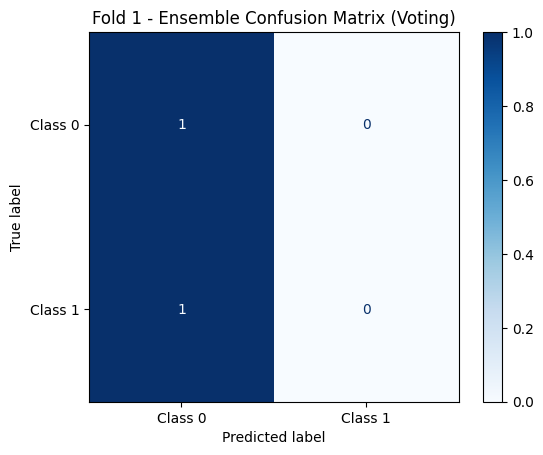

Fold 1 balanced accuracy (ensemble): 0.500

 Fold 2 after voting 


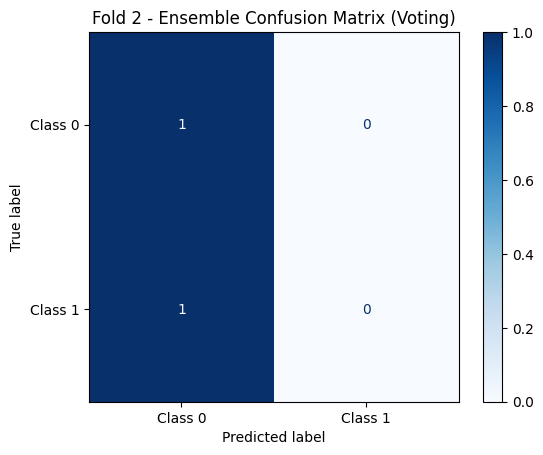

Fold 2 balanced accuracy (ensemble): 0.500

 Fold 3 after voting 


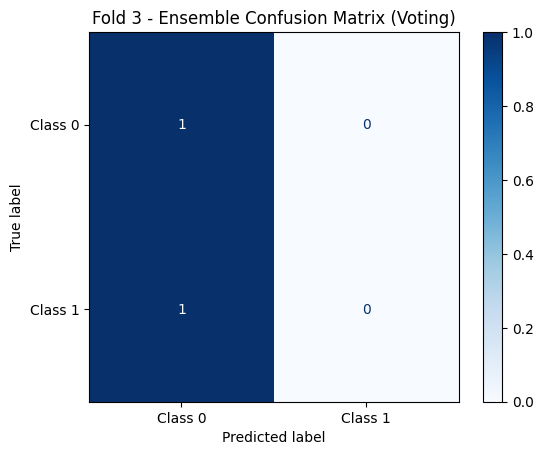

Fold 3 balanced accuracy (ensemble): 0.500

 Fold 4 after voting 


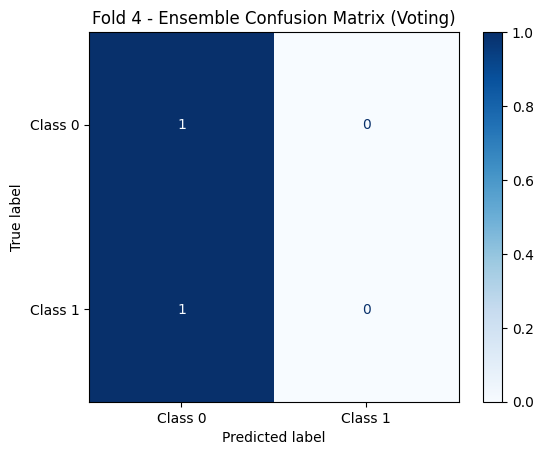

Fold 4 balanced accuracy (ensemble): 0.500

 Fold 5 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


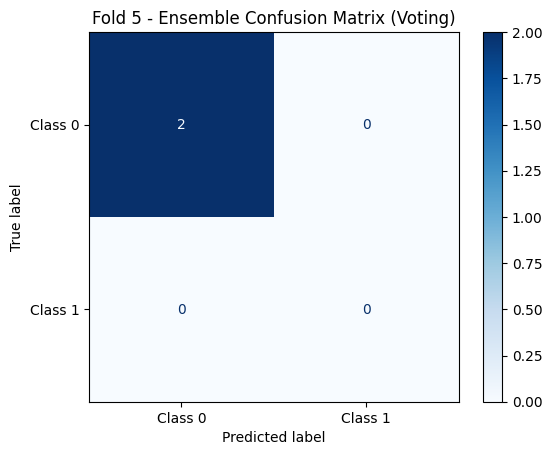

Fold 5 balanced accuracy (ensemble): 1.000

 Fold 6 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


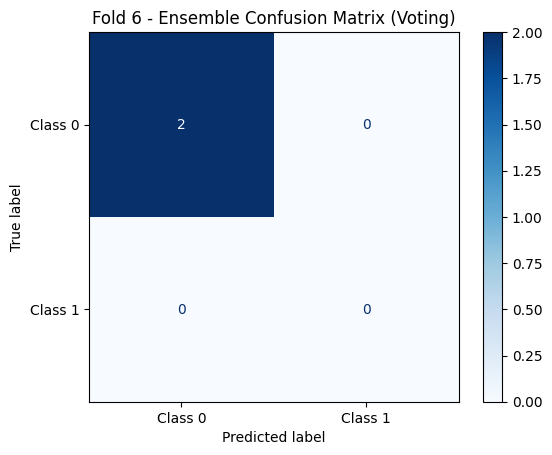

Fold 6 balanced accuracy (ensemble): 1.000

 Fold 7 after voting 


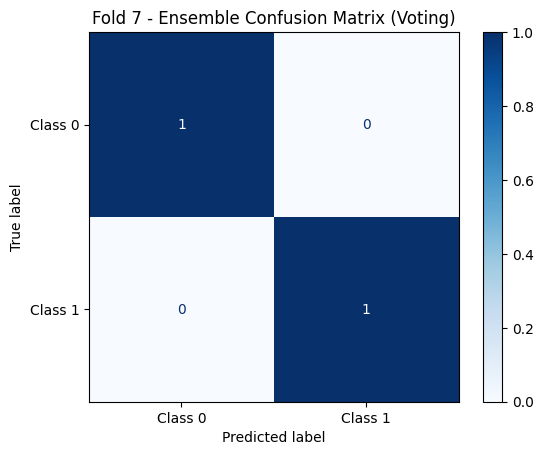

Fold 7 balanced accuracy (ensemble): 1.000

Final Ensemble Mean Balanced Accuracy: 0.714 ± 0.247


In [ ]:
# CatBoost

exercises = {'E12': (X_E12_pos_flat,  patients_E12_pos,  y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

results = {}
# Hyperparameters for each exercise
iterations = [1589, 1637, 819, 1117]
depth = [5, 10, 7, 7]
learning_rate = [0.08590797279838795, 0.07198884820293762, 0.03662946247859701, 0.0564068127448395]
l2_leaf_reg = [6.031458654944161, 4.519350684412103, 5.135681998329912, 1.5780496010871161]
bagging_temperature = [0.8152444324835187, 0.29343372075032714, 0.3417276741189663, 0.3073868691677649]
i = 0

# Loop over exercises
for ex_name, (X, patients, y) in exercises.items():
    print(f"\n{'='*30}\nRunning exercise: {ex_name}\n{'='*30}")

    gkf = GroupKFold(n_splits=7)
    model = CatBoostClassifier(iterations=iterations[i],
                               depth=depth[i],
                               learning_rate=learning_rate[i],
                               l2_leaf_reg=l2_leaf_reg[i],
                               bagging_temperature = bagging_temperature[i],
                               loss_function='Logloss',
                               eval_metric='BalancedAccuracy',
                               early_stopping_rounds=50,
                               random_seed=42,
                               verbose=False)
    bal_acc, f1s = [], []
    fold_predictions = []
    i = i + 1
    # Loop over CV folds
    for fold in range(n_splits):
        train_idx, val_idx = get_fold_indices(patients, fold)
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        patient_val = patients[val_idx]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Aggregate per patient
        unique_patients_val = np.unique(patient_val)
        y_true_patient = []
        y_pred_patient = []
        y_pred_patient_prob = []

        for p in unique_patients_val:
            mask = patient_val == p
            y_true_patient.append(y_val[mask][0])
            mean_prob = np.mean(y_pred_proba[mask])
            y_pred_patient_prob.append(mean_prob)
            y_pred_patient.append(int(mean_prob >= 0.5))

        y_true_patient = np.array(y_true_patient)
        y_pred_patient = np.array(y_pred_patient)
        y_pred_patient_prob = np.array(y_pred_patient_prob)

        # Metrics
        acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
        f1 = f1_score(y_true_patient, y_pred_patient, average="macro")
        bal_acc.append(acc)
        f1s.append(f1)

        print(f"Fold {fold+1}: bal_acc={acc:.3f}, f1={f1:.3f}")

        # Store fold predictions
        fold_predictions.append({"fold": fold + 1,
                                 "patients": unique_patients_val,
                                 "y_true": y_true_patient,
                                 "y_pred": y_pred_patient,
                                 "y_prob": y_pred_patient_prob})

    # Store overall results for this exercise
    results[ex_name] = {"folds": fold_predictions,
                        "metrics": {"mean_bal_acc": np.mean(bal_acc),
                                    "std_bal_acc": np.std(bal_acc),
                                    "mean_f1": np.mean(f1s),
                                    "std_f1": np.std(f1s)}}

    print(f"\n{ex_name} Summary:")
    print(f"Mean Balanced Accuracy: {np.mean(bal_acc):.3f} ± {np.std(bal_acc):.3f}")
    print(f"Mean Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# Voting for final prediction
alpha = 7  # "importance" factor
exercise_names = list(results.keys())
n_splits = len(results[exercise_names[0]]["folds"])

# softmax weights
mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
exp_vals = np.exp(alpha * mean_bal_accs)
softmax_weights = exp_vals / np.sum(exp_vals)

ensemble_bal_acc = []
all_cm = []

for fold_idx in range(n_splits):
    print(f"\n Fold {fold_idx + 1} after voting ")

    # Collect predictions across exercises for this fold
    patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
    y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

    probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

    # Weighted vote (using softmax weights)
    weighted_probs = np.dot(probs_stack, softmax_weights)
    y_pred_fold = (weighted_probs >= 0.5).astype(int)

    # Compute confusion matrix & metrics
    cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
    acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
    ensemble_bal_acc.append(acc)
    all_cm.append(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    disp.ax_.set_title(f"Fold {fold_idx + 1} - Ensemble Confusion Matrix (Voting)")
    plt.show()

    print(f"Fold {fold_idx + 1} balanced accuracy (ensemble): {acc:.3f}")

print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")


In [ ]:
# finding hyperparameters for XGBoost

exercises = {'E12': (X_E12_pos_flat, patients_E12_pos, y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

# Choose one exercise to optimize
X = X_E4_pos_flat.copy()
patients = patients_E4_pos.copy()
y = y_E4_pos.copy()

def objective(trial):
  # Hyperparameters
  n_estimators = trial.suggest_int('n_estimators', 200, 2000)
  max_depth = trial.suggest_int('max_depth', 3, 10)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
  subsample = trial.suggest_float('subsample', 0.6, 1.0)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
  reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True)
  reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True)
  gamma = trial.suggest_float('gamma', 0, 5.0)
  early_stopping_rounds = 50

  model = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        reg_lambda=reg_lambda,
                        reg_alpha=reg_alpha,
                        gamma=gamma,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        tree_method='hist',
                        random_state=42)

  bal_acc = []

  for fold in range(n_splits):
    train_idx, val_idx = get_fold_indices(patients, fold)
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    patient_val = patients[val_idx]

    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    # Aggregate per patient
    unique_patients_val = np.unique(patient_val)
    y_true_patient = []
    y_pred_patient = []

    for p in unique_patients_val:
      mask = patient_val == p
      y_true_patient.append(y_val[mask][0])  # true label for that patient
      mean_prob = np.mean(y_pred_prob[mask])  # mean probability
      y_pred_patient.append(int(mean_prob >= 0.5))  # final patient decision

    y_true_patient = np.array(y_true_patient)
    y_pred_patient = np.array(y_pred_patient)

    # Balanced accuracy at patient-level
    acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
    bal_acc.append(acc)

  return np.mean(bal_acc)

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"Balanced Accuracy Score: {trial.value:.3f}")
print(f"Params: {trial.params}")


[I 2025-10-18 18:55:12,433] A new study created in memory with name: no-name-83adba32-222f-40eb-bd8e-f02584e10b19
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

Best trial:
Balanced Accuracy Score: 0.286
Params: {'n_estimators': 1154, 'max_depth': 9, 'learning_rate': 0.14363000190798944, 'subsample': 0.6839011132862619, 'colsample_bytree': 0.6060174734943813, 'reg_lambda': 0.06480989415465109, 'reg_alpha': 0.06627275311556885, 'gamma': 0.18325392810119745}



Running exercise: E12


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 6: bal_acc=0.000, f1=0.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 7: bal_acc=1.000, f1=1.000

E12 Summary:
Mean Balanced Accuracy: 0.643 ± 0.350
Mean Macro-F1: 0.571 ± 0.387

Running exercise: E3


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.000, f1=0.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 7: bal_acc=0.500, f1=0.333

E3 Summary:
Mean Balanced Accuracy: 0.714 ± 0.364
Mean Macro-F1: 0.667 ± 0.398

Running exercise: E4


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.000, f1=0.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 7: bal_acc=0.500, f1=0.333

E4 Summary:
Mean Balanced Accuracy: 0.643 ± 0.350
Mean Macro-F1: 0.571 ± 0.387

Running exercise: E5
Fold 1: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: bal_acc=0.500, f1=0.333


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.000, f1=0.000
Fold 7: bal_acc=0.500, f1=0.333

E5 Summary:
Mean Balanced Accuracy: 0.500 ± 0.267
Mean Macro-F1: 0.381 ± 0.278

 Fold 1 after voting 


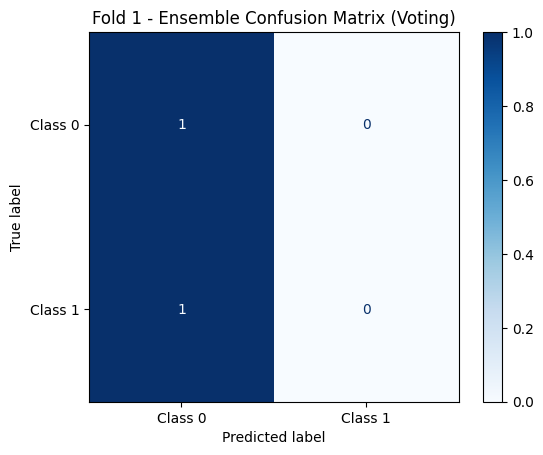

Fold 1 balanced accuracy (ensemble): 0.500

 Fold 2 after voting 


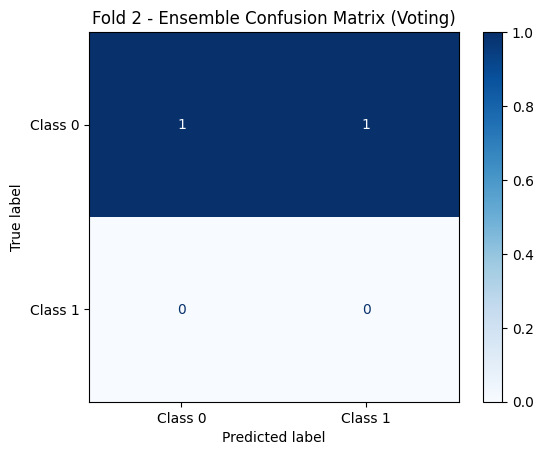

Fold 2 balanced accuracy (ensemble): 0.500

 Fold 3 after voting 


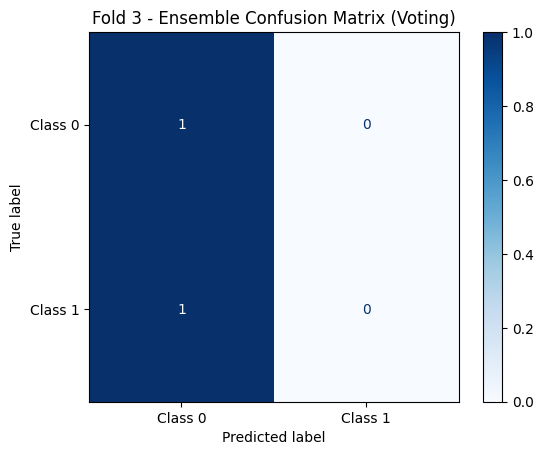

Fold 3 balanced accuracy (ensemble): 0.500

 Fold 4 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


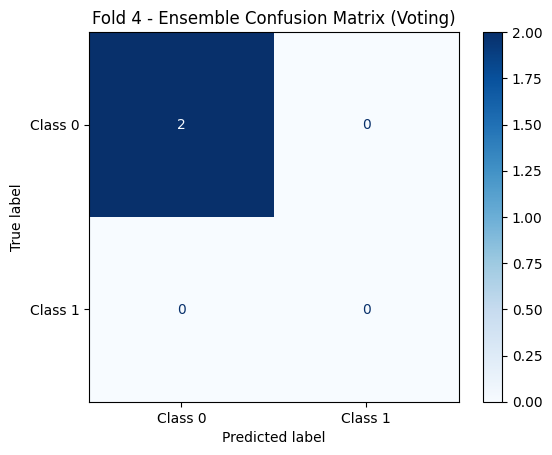

Fold 4 balanced accuracy (ensemble): 1.000

 Fold 5 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


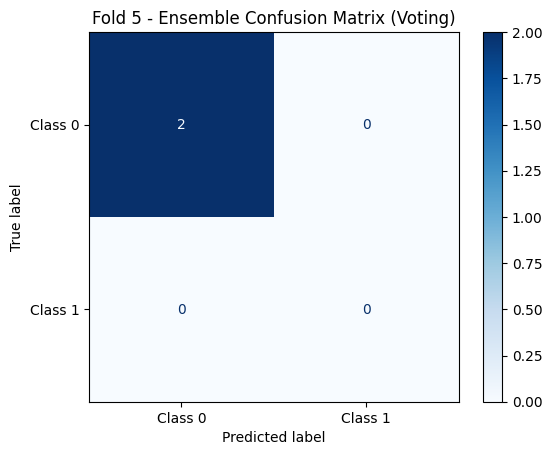

Fold 5 balanced accuracy (ensemble): 1.000

 Fold 6 after voting 


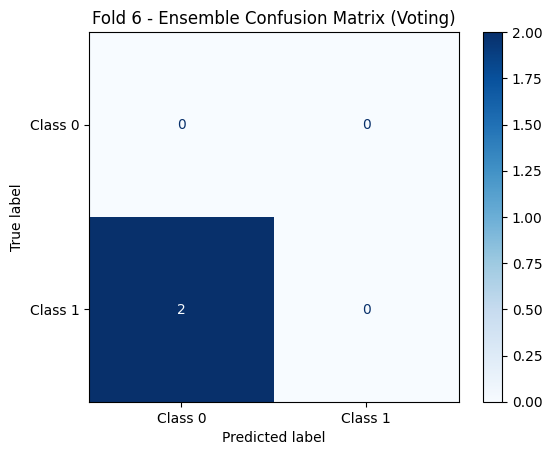

Fold 6 balanced accuracy (ensemble): 0.000

 Fold 7 after voting 


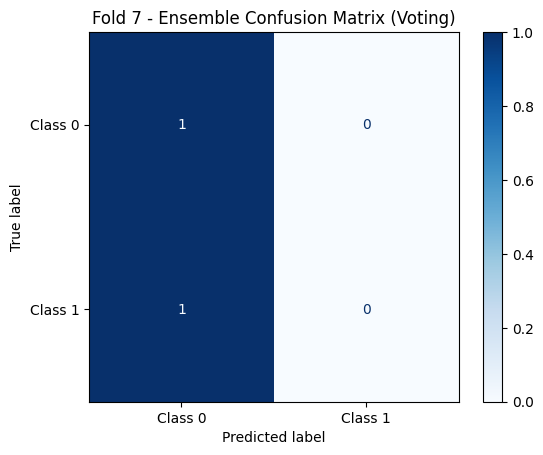

Fold 7 balanced accuracy (ensemble): 0.500

Final Ensemble Mean Balanced Accuracy: 0.571 ± 0.319


In [ ]:
# XGBoost

exercises = {'E12': (X_E12_pos_flat,  patients_E12_pos,  y_E12_pos),
            'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
            'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
            'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

results = {}
# Hyperparameters for each exercise
n_estimators = [1943, 1257, 1935, 1055]
max_depth = [10, 4, 8, 10]
learning_rate = [0.03204842686974214, 0.07034623640012753, 0.011049818729673281, 0.09309241387752763]
subsample = [0.9635545435522274, 0.6011897198894102, 0.6032684473363671, 0.8855399517547952]
colsample_bytree = [0.9971304477886043, 0.6138522227327318, 0.6080213331519883, 0.7433715100562128]
reg_lambda = [0.370210112506449, 6.7736827468579675, 0.0017646106260812099, 2.825263974566119]
reg_alpha = [0.0010377798555485133, 0.002018050956219242, 8.83911049678415, 0.005958908696814273]
gamma = [1.843587643582254, 2.8632395627550715, 0.1390312474236333, 0.16758707759794822]
i = 0

# Loop over exercises
for ex_name, (X, patients, y) in exercises.items():
  print(f"\n{'='*30}\nRunning exercise: {ex_name}\n{'='*30}")

  gkf = GroupKFold(n_splits=7)
  model = XGBClassifier(n_estimators=n_estimators[i],
                    max_depth=max_depth[i],
                    learning_rate=learning_rate[i],
                    subsample=subsample[i],
                    colsample_bytree=colsample_bytree[i],
                    reg_lambda=reg_lambda[i],
                    reg_alpha=reg_alpha[i],
                    gamma=gamma[i],
                    objective='binary:logistic',
                    eval_metric='logloss',
                    use_label_encoder=False,
                    tree_method='hist',
                    random_state=42)
  bal_acc, f1s = [], []
  fold_predictions = []
  i = i + 1
  # Loop over CV folds
  for fold in range(n_splits):
      train_idx, val_idx = get_fold_indices(patients, fold)
      X_train, X_val = X[train_idx], X[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]
      patient_val = patients[val_idx]

      # Fit and predict
      model.fit(X_train, y_train)
      y_pred_proba = model.predict_proba(X_val)[:, 1]

      # Aggregate per patient
      unique_patients_val = np.unique(patient_val)
      y_true_patient = []
      y_pred_patient = []
      y_pred_patient_prob = []

      for p in unique_patients_val:
        mask = patient_val == p
        y_true_patient.append(y_val[mask][0])
        mean_prob = np.mean(y_pred_proba[mask])
        y_pred_patient_prob.append(mean_prob)
        y_pred_patient.append(int(mean_prob >= 0.5))

      y_true_patient = np.array(y_true_patient)
      y_pred_patient = np.array(y_pred_patient)
      y_pred_patient_prob = np.array(y_pred_patient_prob)

      # Metrics
      acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
      f1 = f1_score(y_true_patient, y_pred_patient, average="macro")
      bal_acc.append(acc)
      f1s.append(f1)

      print(f"Fold {fold+1}: bal_acc={acc:.3f}, f1={f1:.3f}")

      # Store fold predictions
      fold_predictions.append({"fold": fold + 1,
                                "patients": unique_patients_val,
                                "y_true": y_true_patient,
                                "y_pred": y_pred_patient,
                                "y_prob": y_pred_patient_prob})

  # Store overall results for this exercise
  results[ex_name] = {"folds": fold_predictions,
                      "metrics": {"mean_bal_acc": np.mean(bal_acc),
                                  "std_bal_acc": np.std(bal_acc),
                                  "mean_f1": np.mean(f1s),
                                  "std_f1": np.std(f1s)}}

  print(f"\n{ex_name} Summary:")
  print(f"Mean Balanced Accuracy: {np.mean(bal_acc):.3f} ± {np.std(bal_acc):.3f}")
  print(f"Mean Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# Voting for final prediction
alpha = 1  # "importance" factor
exercise_names = list(results.keys())
n_splits = len(results[exercise_names[0]]["folds"])

# softmax weights
mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
exp_vals = np.exp(alpha * mean_bal_accs)
softmax_weights = exp_vals / np.sum(exp_vals)

ensemble_bal_acc = []
all_cm = []

for fold_idx in range(n_splits):
  print(f"\n Fold {fold_idx + 1} after voting ")

  # Collect predictions across exercises for this fold
  patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
  y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

  probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

  # Weighted vote (using softmax weights)
  weighted_probs = np.dot(probs_stack, softmax_weights)
  y_pred_fold = (weighted_probs >= 0.5).astype(int)

  # Compute confusion matrix & metrics
  cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
  acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
  ensemble_bal_acc.append(acc)
  all_cm.append(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  disp.ax_.set_title(f"Fold {fold_idx + 1} - Ensemble Confusion Matrix (Voting)")
  plt.show()

  print(f"Fold {fold_idx + 1} balanced accuracy (ensemble): {acc:.3f}")

print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")


In [ ]:
# finding hyperparameters for SVM with RBF

exercises = {'E12': (X_E12_pos_flat, patients_E12_pos, y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

# Choose one exercise to optimize
X = X_E5_pos_flat.copy()
patients = patients_E5_pos.copy()
y = y_E5_pos.copy()

def objective(trial):
  # Suggest hyperparameters
  C = trial.suggest_float('C', 1e-3, 1e2, log=True)
  gamma_choice = trial.suggest_categorical('gamma_choice', ['scale', 'auto', 'float'])
  if gamma_choice == 'float':
    gamma = trial.suggest_float('gamma', 1e-6, 1e1, log=True)
  else:
    gamma = gamma_choice

  # Initialize model
  model = svm.SVC(kernel = 'rbf',
                  C = C,
                  gamma = gamma,
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)

  bal_acc = []

  for fold in range(n_splits):
    train_idx, val_idx = get_fold_indices(patients, fold)
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    patient_val = patients[val_idx]

    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    # Aggregate per patient
    unique_patients_val = np.unique(patient_val)
    y_true_patient = []
    y_pred_patient = []

    for p in unique_patients_val:
      mask = patient_val == p
      y_true_patient.append(y_val[mask][0])  # true label for that patient
      mean_prob = np.mean(y_pred_prob[mask])  # mean probability
      y_pred_patient.append(int(mean_prob >= 0.5))  # final patient decision

    y_true_patient = np.array(y_true_patient)
    y_pred_patient = np.array(y_pred_patient)

    # Balanced accuracy at patient-level
    acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
    bal_acc.append(acc)

  return np.mean(bal_acc)

# Optuna optimization
study = optuna.create_study(direction="maximize", study_name="SVM_RBF_tuning_E5_cSS", storage="sqlite:///optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial
print(f"Balanced Accuracy Score: {trial.value:.3f}")
print(f"Params: {trial.params}")


[I 2025-10-18 20:20:43,877] Using an existing study with name 'SVM_RBF_tuning_E5_cSS' instead of creating a new one.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
[I 2025-10-18 20:20:44,418] Trial 400 finished with value: 0.21428571428571427 and pa

Best trial:
Balanced Accuracy Score: 0.929
Params: {'C': 0.13478447415369485, 'gamma_choice': 'float', 'gamma': 2.033904616843002e-06}



Running exercise: E12
Fold 1: bal_acc=0.000, f1=0.000
Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=1.000, f1=1.000
Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=1.000, f1=1.000
Fold 7: bal_acc=1.000, f1=1.000
Fold 8: bal_acc=1.000, f1=1.000
Fold 9: bal_acc=1.000, f1=1.000
Fold 10: bal_acc=1.000, f1=1.000
Fold 11: bal_acc=1.000, f1=1.000
Fold 12: bal_acc=1.000, f1=1.000
Fold 13: bal_acc=1.000, f1=1.000
Fold 14: bal_acc=1.000, f1=1.000

E12 Summary:
Mean Balanced Accuracy: 0.929 ± 0.258
Mean Macro-F1: 0.929 ± 0.258

Running exercise: E3
Fold 1: bal_acc=0.000, f1=0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=1.000, f1=1.000
Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=1.000, f1=1.000
Fold 7: bal_acc=1.000, f1=1.000
Fold 8: bal_acc=1.000, f1=1.000
Fold 9: bal_acc=0.000, f1=0.000
Fold 10: bal_acc=1.000, f1=1.000
Fold 11: bal_acc=1.000, f1=1.000
Fold 12: bal_acc=0.000, f1=0.000
Fold 13: bal_acc=0.000, f1=0.000
Fold 14: bal_acc=1.000, f1=1.000

E3 Summary:
Mean Balanced Accuracy: 0.714 ± 0.452
Mean Macro-F1: 0.714 ± 0.452

Running exercise: E4
Fold 1: bal_acc=1.000, f1=1.000
Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=1.000, f1=1.000
Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=0.000, f1=0.000
Fold 6: bal_acc=1.000, f1=1.000
Fold 7: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

Fold 8: bal_acc=0.000, f1=0.000
Fold 9: bal_acc=1.000, f1=1.000
Fold 10: bal_acc=1.000, f1=1.000
Fold 11: bal_acc=1.000, f1=1.000
Fold 12: bal_acc=1.000, f1=1.000
Fold 13: bal_acc=1.000, f1=1.000
Fold 14: bal_acc=1.000, f1=1.000

E4 Summary:
Mean Balanced Accuracy: 0.857 ± 0.350
Mean Macro-F1: 0.857 ± 0.350

Running exercise: E5
Fold 1: bal_acc=1.000, f1=1.000
Fold 2: bal_acc=1.000, f1=1.000
Fold 3: bal_acc=1.000, f1=1.000
Fold 4: bal_acc=1.000, f1=1.000
Fold 5: bal_acc=1.000, f1=1.000
Fold 6: bal_acc=0.000, f1=0.000
Fold 7: bal_acc=1.000, f1=1.000
Fold 8: bal_acc=1.000, f1=1.000
Fold 9: bal_acc=1.000, f1=1.000
Fold 10: bal_acc=1.000, f1=1.000
Fold 11: bal_acc=1.000, f1=1.000
Fold 12: bal_acc=1.000, f1=1.000
Fold 13: bal_acc=1.000, f1=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

Fold 14: bal_acc=1.000, f1=1.000

E5 Summary:
Mean Balanced Accuracy: 0.929 ± 0.258
Mean Macro-F1: 0.929 ± 0.258

 Fold 1 after voting 


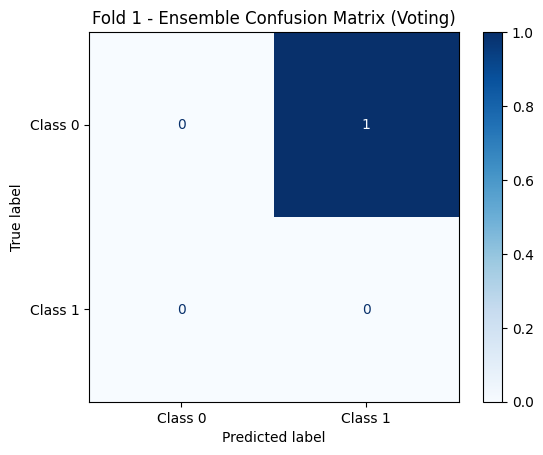

Fold 1 balanced accuracy (ensemble): 0.000

 Fold 2 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


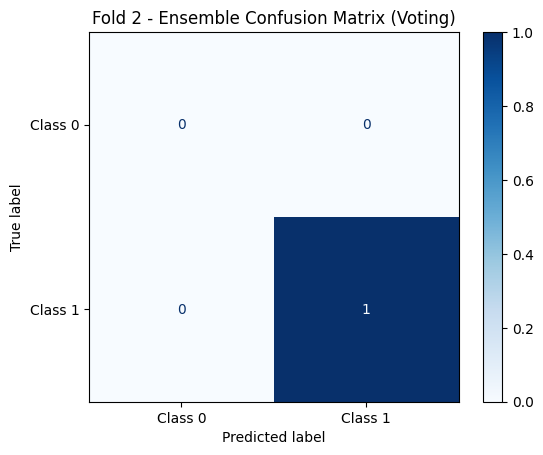

Fold 2 balanced accuracy (ensemble): 1.000

 Fold 3 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


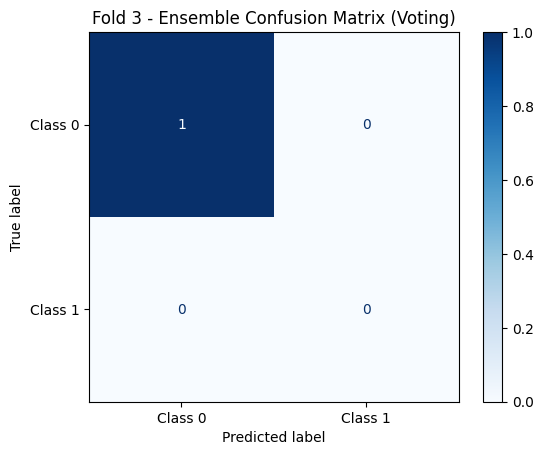

Fold 3 balanced accuracy (ensemble): 1.000

 Fold 4 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


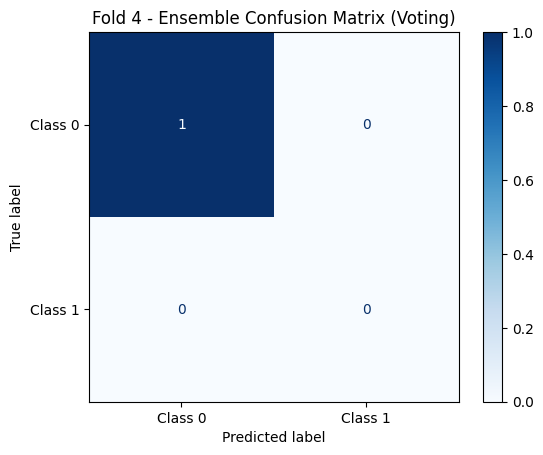

Fold 4 balanced accuracy (ensemble): 1.000

 Fold 5 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


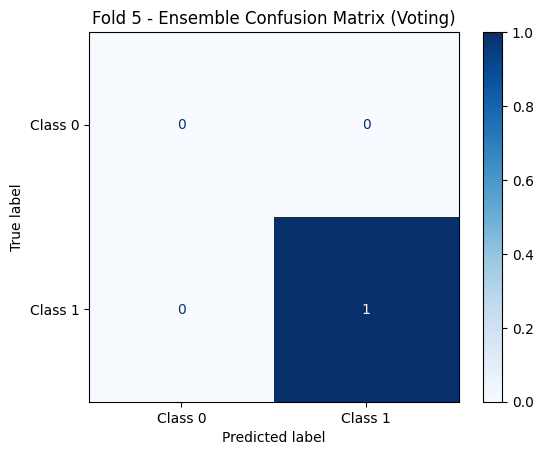

Fold 5 balanced accuracy (ensemble): 1.000

 Fold 6 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


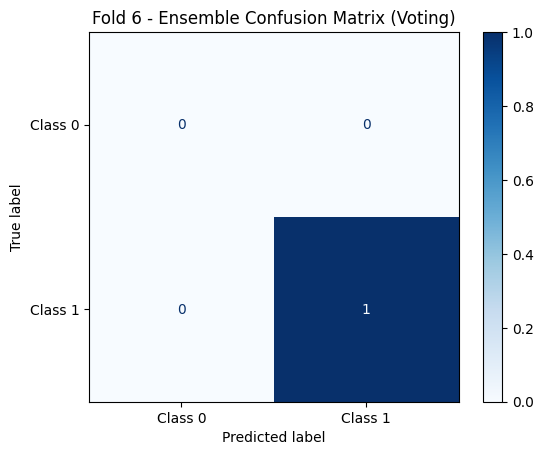

Fold 6 balanced accuracy (ensemble): 1.000

 Fold 7 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


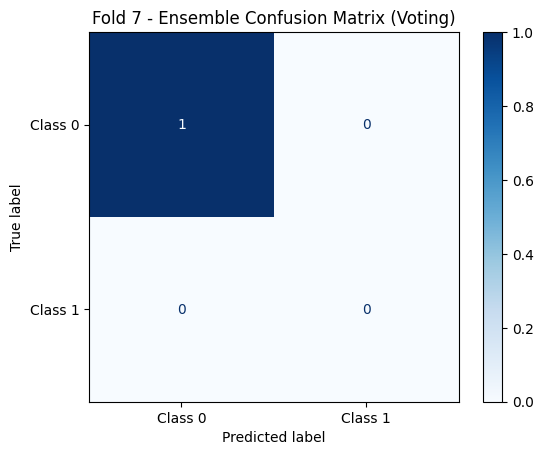

Fold 7 balanced accuracy (ensemble): 1.000

 Fold 8 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


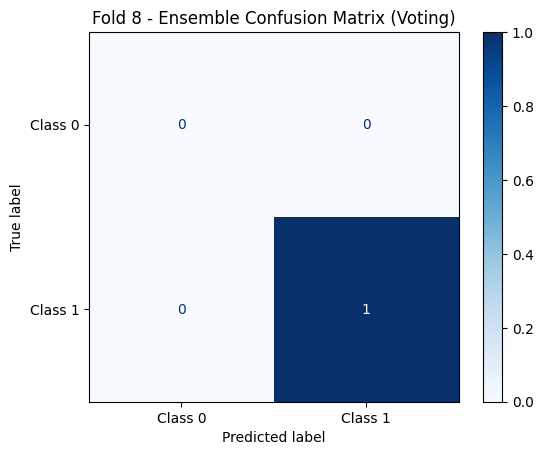

Fold 8 balanced accuracy (ensemble): 1.000

 Fold 9 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


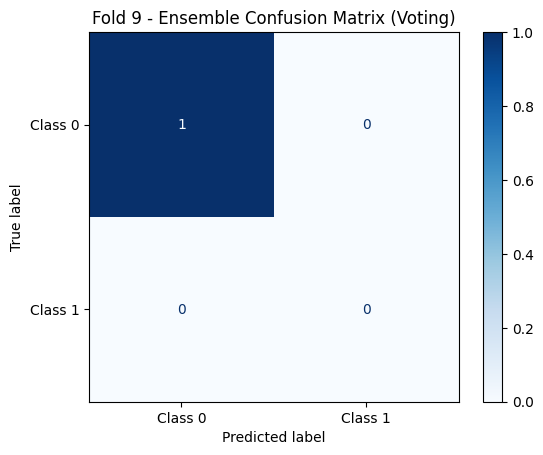

Fold 9 balanced accuracy (ensemble): 1.000

 Fold 10 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


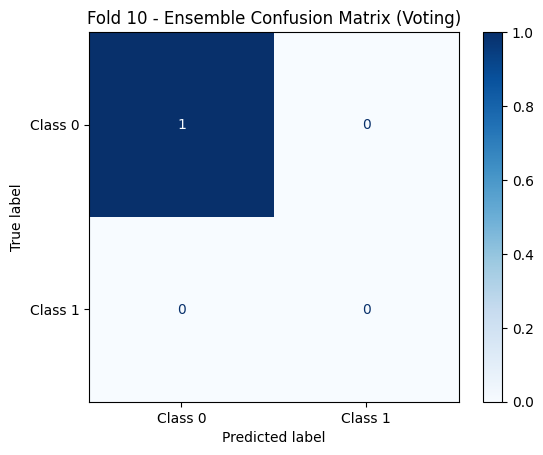

Fold 10 balanced accuracy (ensemble): 1.000

 Fold 11 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


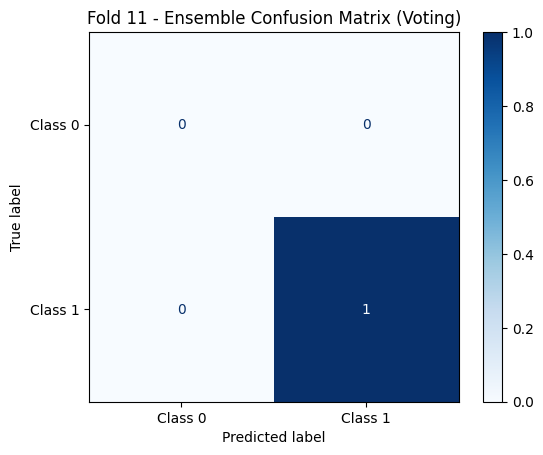

Fold 11 balanced accuracy (ensemble): 1.000

 Fold 12 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


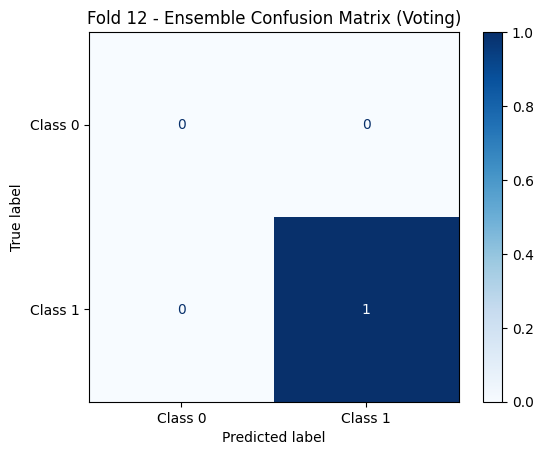

Fold 12 balanced accuracy (ensemble): 1.000

 Fold 13 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


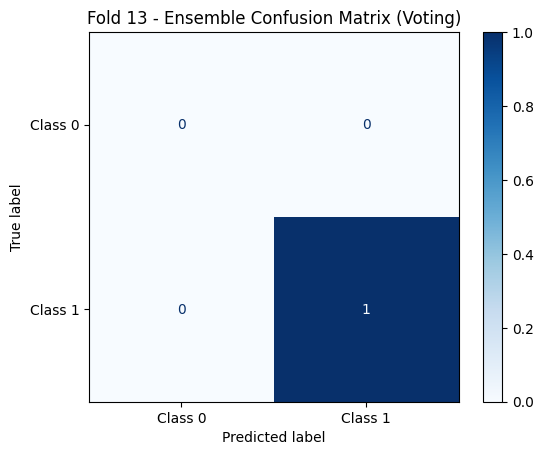

Fold 13 balanced accuracy (ensemble): 1.000

 Fold 14 after voting 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


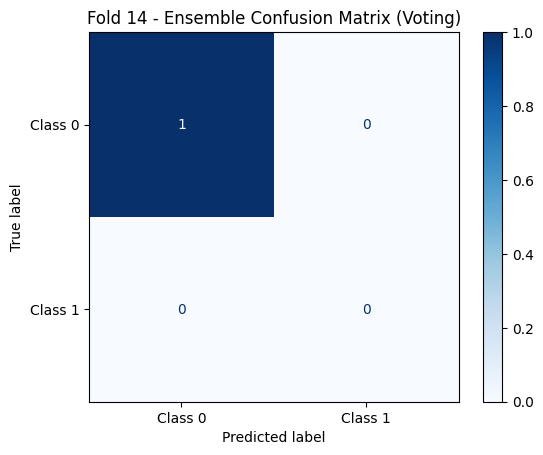

Fold 14 balanced accuracy (ensemble): 1.000

Final Ensemble Mean Balanced Accuracy: 0.929 ± 0.258


In [ ]:
# SVM RBF

exercises = {'E12': (X_E12_pos_flat,  patients_E12_pos,  y_E12_pos),
             'E3':  (X_E3_pos_flat,  patients_E3_pos,  y_E3_pos),
             'E4':  (X_E4_pos_flat,  patients_E4_pos,  y_E4_pos),
             'E5':  (X_E5_pos_flat,  patients_E5_pos,  y_E5_pos)}

# Hyperparameters for each exercise
C = [0.07548793285556035, 0.5300146917714448, 0.1790580953354273, 0.13478447415369485]
gamma = ['auto', 0.37397320313059884, 1.1340337640727483e-05, 2.033904616843002e-06]
i = 0
results = {}

# Loop over exercises
for ex_name, (X, patients, y) in exercises.items():
  print(f"\n{'='*30}\nRunning exercise: {ex_name}\n{'='*30}")

  model = svm.SVC(kernel = 'rbf',
                  C = C[i],
                  gamma = gamma[i],
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)
  bal_acc, f1s = [], []
  fold_predictions = []
  i = i + 1
  # Loop over CV folds
  for fold in range(n_splits):
    train_idx, val_idx = get_fold_indices(patients, fold)
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    patient_val = patients[val_idx]

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Aggregate per patient
    unique_patients_val = np.unique(patient_val)
    y_true_patient = []
    y_pred_patient = []
    y_pred_patient_prob = []

    for p in unique_patients_val:
      mask = patient_val == p
      y_true_patient.append(y_val[mask][0])
      mean_prob = np.mean(y_pred_proba[mask])
      y_pred_patient_prob.append(mean_prob)
      y_pred_patient.append(int(mean_prob >= 0.5))

    y_true_patient = np.array(y_true_patient)
    y_pred_patient = np.array(y_pred_patient)
    y_pred_patient_prob = np.array(y_pred_patient_prob)

    # Metrics
    acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
    f1 = f1_score(y_true_patient, y_pred_patient, average="macro")
    bal_acc.append(acc)
    f1s.append(f1)

    print(f"Fold {fold+1}: bal_acc={acc:.3f}, f1={f1:.3f}")

    # Store fold predictions
    fold_predictions.append({"fold": fold + 1,
                              "patients": unique_patients_val,
                              "y_true": y_true_patient,
                              "y_pred": y_pred_patient,
                              "y_prob": y_pred_patient_prob})

    # Store overall results for this exercise
    results[ex_name] = {"folds": fold_predictions,
                        "metrics": {"mean_bal_acc": np.mean(bal_acc),
                                    "std_bal_acc": np.std(bal_acc),
                                    "mean_f1": np.mean(f1s),
                                    "std_f1": np.std(f1s)}}

  print(f"\n{ex_name} Summary:")
  print(f"Mean Balanced Accuracy: {np.mean(bal_acc):.3f} ± {np.std(bal_acc):.3f}")
  print(f"Mean Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# Voting for final prediction
alpha = 7  # "importance" factor
exercise_names = list(results.keys())
n_splits = len(results[exercise_names[0]]["folds"])

# softmax weights
mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
exp_vals = np.exp(alpha * mean_bal_accs)
softmax_weights = exp_vals / np.sum(exp_vals)

ensemble_bal_acc = []
all_cm = []

for fold_idx in range(n_splits):
  print(f"\n Fold {fold_idx + 1} after voting ")

  # Collect predictions across exercises for this fold
  patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
  y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

  probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

  # Weighted vote (using softmax weights)
  weighted_probs = np.dot(probs_stack, softmax_weights)
  y_pred_fold = (weighted_probs >= 0.5).astype(int)

  # Compute confusion matrix & metrics
  cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
  acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
  ensemble_bal_acc.append(acc)
  all_cm.append(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  disp.ax_.set_title(f"Fold {fold_idx + 1} - Ensemble Confusion Matrix (Voting)")
  plt.show()

  print(f"Fold {fold_idx + 1} balanced accuracy (ensemble): {acc:.3f}")

print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")

In [ ]:
# Weights for voting
print("Softmax weights:", dict(zip(exercise_names, softmax_weights)))


Softmax weights: {'E12': 0.3533992459382818, 'E3': 0.07885403034254317, 'E4': 0.21434747778089328, 'E5': 0.3533992459382818}


In [ ]:
# Testing different alpha values
for alpha in range(10):
  exercise_names = list(results.keys())
  n_splits = len(results[exercise_names[0]]["folds"])

  # softmax weights
  mean_bal_accs = np.array([results[ex]["metrics"]["mean_bal_acc"] for ex in exercise_names])
  exp_vals = np.exp(alpha * mean_bal_accs)
  softmax_weights = exp_vals / np.sum(exp_vals)

  ensemble_bal_acc = []
  all_cm = []

  for fold_idx in range(n_splits):
    # Predictions across exercises for this fold
    patients_fold = results[exercise_names[0]]["folds"][fold_idx]["patients"]
    y_true_fold = results[exercise_names[0]]["folds"][fold_idx]["y_true"]

    probs_stack = np.stack([results[ex]["folds"][fold_idx]["y_prob"] for ex in exercise_names], axis=1)

    # Weighted vote (using softmax weights)
    weighted_probs = np.dot(probs_stack, softmax_weights)
    y_pred_fold = (weighted_probs >= 0.5).astype(int)

    # Compute confusion matrix & metrics
    cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
    acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
    ensemble_bal_acc.append(acc)
    all_cm.append(cm)

  print(f"\nFinal Ensemble Mean Balanced Accuracy: {np.mean(ensemble_bal_acc):.3f} ± {np.std(ensemble_bal_acc):.3f}")


Final Ensemble Mean Balanced Accuracy: 0.786 ± 0.410

Final Ensemble Mean Balanced Accuracy: 0.786 ± 0.410

Final Ensemble Mean Balanced Accuracy: 0.786 ± 0.410

Final Ensemble Mean Balanced Accuracy: 0.786 ± 0.410

Final Ensemble Mean Balanced Accuracy: 0.857 ± 0.350

Final Ensemble Mean Balanced Accuracy: 0.857 ± 0.350

Final Ensemble Mean Balanced Accuracy: 0.857 ± 0.350

Final Ensemble Mean Balanced Accuracy: 0.929 ± 0.258

Final Ensemble Mean Balanced Accuracy: 0.929 ± 0.258

Final Ensemble Mean Balanced Accuracy: 0.929 ± 0.258


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

# Some other (but not all) features per exercise

- min, max of x, y across time
- moving average
- Median, percentiles (25th/75th)
- Velocity
- Angle features
- Range of motion, total path length

In [ ]:
remove_points = [1,2,3,4,5,6,7,8,9,10,  # face
                 17,19,21,               # left hand
                 16,18,20,               # right hand
                 23,24,                   # hips
                 29,31,                  # left foot
                 30,32]                  # right foot

def RemovePoints(seq, remove_points):

    keep_points = [i for i in range(seq.shape[1]) if i not in remove_points]
    return seq[:, keep_points, :]

# Example for all sequences in your dataframe
X_interp_feat = X_interp.copy()
X_interp_feat["Skeleton_Sequence_reduced"] = X_interp["Skeleton_Sequence"].apply(lambda x: RemovePoints(np.array(x), remove_points))

# check shape
print(X_interp_feat["Skeleton_Sequence_reduced"].iloc[0].shape)

# Features for E1 (brushing hair)
remove_points_lower = [0,1,2,3,4,5,6,7,8,9,10,   # face
                       17,19,21,               # left hand
                       16,18,20,               # right hand
                       27,29,31,               # left foot
                       28,30,32,               # right foot
                       25,26]                  #knees


(100, 11, 2)


In [ ]:
seq_1 = X_interp["Skeleton_Sequence"].iloc[0][:,15,1]
kernel = np.ones(5) / 5
print(np.convolve(seq_1, kernel, mode='same'))

[0.03725109 0.04987865 0.06425111 0.06540991 0.06576934 0.06903029
 0.07145812 0.07218251 0.07303082 0.07177654 0.06642555 0.0616493
 0.05796756 0.05426565 0.05275497 0.05211842 0.04952489 0.04708528
 0.04866661 0.05080654 0.05407313 0.05912795 0.06271669 0.06356873
 0.06307742 0.0594889  0.05712052 0.05560335 0.05401482 0.05374862
 0.05477411 0.05571239 0.05670486 0.05552397 0.05621893 0.05701479
 0.05752567 0.05698835 0.06275088 0.06649377 0.07003171 0.07338195
 0.07309018 0.06849045 0.0611293  0.05852201 0.05363606 0.05364951
 0.05129347 0.05494883 0.05404227 0.05501855 0.05576675 0.05910144
 0.05758686 0.05703091 0.058913   0.05416196 0.05281744 0.05070655
 0.05150987 0.05054577 0.05321886 0.05382355 0.05776798 0.06049483
 0.06185252 0.06494694 0.06788121 0.06776001 0.06652618 0.0655593
 0.06513814 0.06476139 0.06596673 0.06693328 0.06891167 0.06930889
 0.06697238 0.06440502 0.06183317 0.05803392 0.0560947  0.05804684
 0.05942675 0.05781008 0.05638491 0.05477589 0.05164284 0.050291

In [ ]:
def AngleAtb(a, b, c):
  # angle at b formed by points a-b-c
  ba = a - b
  bc = c - b
  dot = np.sum(ba * bc, axis=-1)
  denom = np.linalg.norm(ba, axis=-1) * np.linalg.norm(bc, axis=-1)
  denom = np.where(denom == 0, 1e-8, denom)
  cos = np.clip(dot / denom, -1.0, 1.0)
  return np.arccos(cos)

# features for brushing hair and brushing teeth (E1 and E2)
def FeaturesE12(seq):
  joints = {'L_shoulder': 11, 'R_shoulder': 12,
            'L_elbow': 13, 'R_elbow': 14,
            'L_wrist': 15, 'R_wrist': 16,
            'L_hip': 23, 'R_hip': 24}

  # min, max and std
  pos_feats = []
  for name in ['L_wrist','R_wrist']:
    j = joints[name]
    x = seq[:, j, 0]
    y = seq[:, j, 1]
    pos_feats.extend([x.min(), x.max(), y.min(), y.max(), x.std(), y.std()])

  # moving average
  ma_feats = [] # not using
  kernel = np.ones(5) / 5
  for name in ['L_wrist', 'R_wrist']:
    j = joints[name]
    ma_x = np.convolve(seq[:, j, 0], kernel, mode='same')
    ma_y = np.convolve(seq[:, j, 1], kernel, mode='same')

    ma_feats.extend([np.percentile(ma_x, 25), np.percentile(ma_x, 75),
                     np.percentile(ma_y, 25), np.percentile(ma_y, 75)])

  # velocity features
  vel_feats = []

  for name in ['L_elbow','R_elbow','L_wrist','R_wrist']:
    j = joints[name]
    vel = np.diff(seq[:, j, :], axis=0)
    vel_mag = np.linalg.norm(vel, axis=1)

    # velocity statistics
    vel_feats.extend([vel_mag.std(), np.median(vel_mag),
                      np.percentile(vel_mag,25), np.percentile(vel_mag,75),
                      skew(vel_mag)])

  # asymmetry ratios
  asym_feats = []
  for l,r in [('L_shoulder','R_shoulder')]:
    l_idx, r_idx = joints[l], joints[r]
    ratio = (seq[:,l_idx,:] - seq[:,r_idx,:]) / (seq[:,l_idx,:] + seq[:,r_idx,:] + 1e-6)
    asym_feats.extend([ratio[:,0].mean(), ratio[:,0].std(), ratio[:,1].mean(), ratio[:,1].std()])

  # range of motion
  range_feats = []
  for name in ['L_wrist','R_wrist']:
    j = joints[name]
    diffs = np.diff(seq[:,j,:], axis=0)
    path_len = np.sum(np.linalg.norm(diffs, axis=1))
    x_range = seq[:,j,0].max() - seq[:,j,0].min()
    y_range = seq[:,j,1].max() - seq[:,j,1].min()
    range_feats.extend([path_len, x_range, y_range])

  features = np.concatenate([pos_feats, vel_feats, asym_feats, range_feats])
  return features

In [ ]:
# features for washing face (E3)
def FeaturesE3(seq):
  joints = {'L_shoulder': 11, 'R_shoulder': 12,
              'L_elbow': 13, 'R_elbow': 14,
              'L_wrist': 15, 'R_wrist': 16,
              'Nose': 0}

  # min and max
  pos_feats = []
  for name in ['L_wrist','R_wrist']:
    j = joints[name]
    x = seq[:, j, 0]
    y = seq[:, j, 1]
    pos_feats.extend([x.min(), x.max(), y.min(), y.max()])

  # hand to nose distance
  wrist_dists = []
  dist_feats = []
  for name in ['L_wrist','R_wrist']:
    nose_idx = joints['Nose']
    j = joints[name]
    d = np.linalg.norm(seq[:, j, :] - seq[:, nose_idx, :], axis=1)
    wrist_dists.append(d)
    dist_feats.extend([d.mean(), d.std(), np.percentile(d,25), np.percentile(d,75)])

  # elbow forearm angle
  angle_feats = []
  elbow_angles = []
  L_angle = AngleAtb(seq[:, joints['L_shoulder'], :], seq[:, joints['L_elbow'], :], seq[:, joints['L_wrist'], :])
  R_angle = AngleAtb(seq[:, joints['R_shoulder'], :], seq[:, joints['R_elbow'], :], seq[:, joints['R_wrist'], :])
  angle_feats = [L_angle.mean(), L_angle.std(), np.percentile(L_angle,25), np.percentile(L_angle,75),
                 R_angle.mean(), R_angle.std(), np.percentile(R_angle,25), np.percentile(R_angle,75)]

  # moving average
  ma_feats = []
  kernel = np.ones(5) / 5
  for name in ['L_wrist', 'R_wrist']:
    j = joints[name]
    ma_x = np.convolve(seq[:, j, 0], kernel, mode='same')
    ma_y = np.convolve(seq[:, j, 1], kernel, mode='same')
    ma_mag = np.linalg.norm(np.vstack([ma_x, ma_y]).T, axis=1)
    ma_feats = [ma_mag.mean(), ma_mag.std(), np.percentile(ma_mag, 25), np.percentile(ma_mag, 75)]


  # velocity feature
  vel_feats = []
  vel_mag_list = []
  for e, w in [('L_elbow','L_wrist'),('R_elbow','R_wrist')]:
    elbow = joints[e]
    wrist = joints[w]
    vel = np.diff(seq[:, elbow, :], axis=0) + np.diff(seq[:, wrist, :], axis=0)
    vel_mag = np.linalg.norm(vel, axis=1)
    vel_mag_list.append(vel_mag)

    # velocity statistics
    vel_feats.extend([vel_mag.mean(), vel_mag.std(), skew(vel_mag)])

    fft = np.fft.rfft(vel_mag)
    psd = np.abs(fft)**2
    # high frequency energy
    hf_energy = psd[int(len(psd)*0.75):].sum() / (psd.sum() + 1e-6)
    vel_feats.append(hf_energy)

  # asymmetry ratios
  asym_feats = []
  # wrist distance to nose
  asym_d = (wrist_dists[0] - wrist_dists[1]) / (wrist_dists[0] + wrist_dists[1] + 1e-6)
  asym_feats.extend([asym_d.mean(), asym_d.std(), np.percentile(asym_d,25), np.percentile(asym_d,75)])
  # wrist velocity
  asym_v = (vel_mag_list[0] - vel_mag_list[1]) / (vel_mag_list[0] + vel_mag_list[1] + 1e-6)
  asym_feats.extend([asym_v.mean(), asym_v.std(), np.percentile(asym_v,25), np.percentile(asym_v,75)])
  # elbow angles
  asym_a = (L_angle - R_angle) / (L_angle + R_angle + 1e-6)
  asym_feats.extend([asym_a.mean(), asym_a.std(), np.percentile(asym_a,25), np.percentile(asym_a,75)])

  features = np.concatenate([pos_feats, dist_feats, angle_feats, ma_feats, vel_feats, asym_feats])
  return features

In [ ]:
# Features for putting socks (E4)
def FeaturesE4(seq):
  joints = {'L_shoulder': 11, 'R_shoulder': 12,
            'L_foot': 27, 'R_foot': 28,
            'L_wrist': 15, 'R_wrist': 16}

  # min and max
  pos_feats = []
  for name in ['L_wrist','R_wrist']:
    j = joints[name]
    x = seq[:, j, 0]
    y = seq[:, j, 1]
    pos_feats.extend([x.min(), x.max(), y.min(), y.max()])

  # hand to foot distance
  wrist_dists = []
  dist_feats = []
  for side in ['L', 'R']:
    w = joints[f'{side}_wrist']
    f = joints[f'{side}_foot']
    d = np.linalg.norm(seq[:, w, :] - seq[:, f, :], axis=1)
    wrist_dists.append(d)
    dist_feats.extend([d.mean(), d.std(), np.percentile(d,25), np.percentile(d,75)])

  # moving average
  ma_feats = []
  kernel = np.ones(5) / 5
  for name in ['L_wrist', 'R_wrist']:
    j = joints[name]
    ma_x = np.convolve(seq[:, j, 0], kernel, mode='same')
    ma_y = np.convolve(seq[:, j, 1], kernel, mode='same')
    ma_mag = np.linalg.norm(np.vstack([ma_x, ma_y]).T, axis=1)
    ma_feats = [ma_mag.mean(), ma_mag.std(), np.percentile(ma_mag, 25), np.percentile(ma_mag, 75)]

  # velocity and espectral features
  vel_feats = []
  vel_mag_list = []
  for name in ['L_wrist','R_wrist', 'L_foot', 'R_foot']:
    j = joints[name]
    vel = np.diff(seq[:, j, :], axis=0)

    vel_mag = np.linalg.norm(vel, axis=1)
    vel_mag_list.append(vel_mag)

    # velocity statistics
    vel_feats.extend([vel_mag.mean(), vel_mag.std(), skew(vel_mag)])

    fft = np.fft.rfft(vel_mag)
    psd = np.abs(fft)**2
    # high frequency energy
    hf_energy = psd[int(len(psd)*0.75):].sum() / (psd.sum() + 1e-6)
    vel_feats.append(hf_energy)

  # asymmetry ratios
  asym_feats = []
  # wrist distance to foot
  asym_d = (wrist_dists[0] - wrist_dists[1]) / (wrist_dists[0] + wrist_dists[1] + 1e-6)
  asym_feats.extend([asym_d.mean(), asym_d.std(), np.percentile(asym_d,25), np.percentile(asym_d,75)])
  # wrist velocity
  asym_v = (vel_mag_list[0] - vel_mag_list[1]) / (vel_mag_list[0] + vel_mag_list[1] + 1e-6)
  asym_feats.extend([asym_v.mean(), asym_v.std(), np.percentile(asym_v,25), np.percentile(asym_v,75)])

  features = np.concatenate([pos_feats, dist_feats, vel_feats, asym_feats])
  return features

In [ ]:
# features for hip flection (E5)
def FeaturesE5(seq):
  joints = {'L_hip': 23, 'R_hip': 24,
            'L_knee': 25, 'R_knee': 26,
            'L_foot': 27, 'R_foot': 28,
            'L_wrist': 15, 'R_wrist': 16}

  # min and max
  pos_feats = []
  for name in ['L_knee','R_knee']:
    j = joints[name]
    x = seq[:, j, 0]
    y = seq[:, j, 1]
    pos_feats.extend([x.min(), x.max(), y.min(), y.max()])

  # hip to foot distance
  foot_dists = []
  dist_feats = []
  for side in ['L', 'R']:
    w = joints[f'{side}_hip']
    f = joints[f'{side}_foot']
    d = np.linalg.norm(seq[:, w, :] - seq[:, f, :], axis=1)
    foot_dists.append(d)
    dist_feats.extend([d.mean(), d.std(), np.percentile(d,25), np.percentile(d,75)])

  # moving average
  ma_feats = []
  kernel = np.ones(5) / 5
  for name in ['L_knee', 'R_knee']:
    j = joints[name]
    ma_x = np.convolve(seq[:, j, 0], kernel, mode='same')
    ma_y = np.convolve(seq[:, j, 1], kernel, mode='same')

    ma_feats.extend([ma_x.mean(), ma_x.std(), ma_y.mean(), ma_y.std()])

  # velocity and espectral features
  vel_feats = []
  vel_mag_list = []
  for name in ['L_knee','R_knee', 'L_hip', 'R_hip']:
    j = joints[name]
    vel = np.diff(seq[:, j, :], axis=0)
    vel_mag = np.linalg.norm(vel, axis=1)
    vel_mag_list.append(vel_mag)

    # velocity statistics
    vel_feats.extend([vel_mag.mean(), vel_mag.std(), np.median(vel_mag), skew(vel_mag)])

    fft = np.fft.rfft(vel_mag)
    psd = np.abs(fft)**2
    # high frequency energy
    hf_energy = psd[int(len(psd)*0.75):].sum() / (psd.sum() + 1e-6)
    vel_feats.append(hf_energy)

  # foot knee hip angle
  angle_feats = []
  elbow_angles = []
  L_angle = AngleAtb(seq[:, joints['L_foot'], :], seq[:, joints['L_knee'], :], seq[:, joints['L_hip'], :])
  R_angle = AngleAtb(seq[:, joints['R_foot'], :], seq[:, joints['R_knee'], :], seq[:, joints['R_hip'], :])
  angle_feats = [L_angle.mean(), L_angle.std(),R_angle.mean(), R_angle.std()]

  # asymmetry ratios
  asym_feats = []
  # foot distance to hip
  asym_d = (foot_dists[0] - foot_dists[1]) / (foot_dists[0] + foot_dists[1] + 1e-6)
  asym_feats.extend([asym_d.mean(), asym_d.std()])
  # wrist velocity
  asym_v = (vel_mag_list[0] - vel_mag_list[1]) / (vel_mag_list[0] + vel_mag_list[1] + 1e-6)
  asym_feats.extend([asym_v.mean(), asym_v.std()])
  # knee angles
  asym_a = (L_angle - R_angle) / (L_angle + R_angle + 1e-6)
  asym_feats.extend([asym_a.mean(), asym_a.std()])

  features = np.concatenate([pos_feats, dist_feats, vel_feats, asym_feats, angle_feats])
  return features

In [ ]:
# Sets for each exercise with respective features

# dividing data into exercices
exercise_types = X_interp['Exercise_Id'].unique()
exercise_dfs = {ex: X_interp[X_interp['Exercise_Id'] == ex] for ex in exercise_types}

# Exercise 1 and 2
E12 = pd.concat([exercise_dfs['E1'], exercise_dfs['E2']], ignore_index=True)

FeatListE12 = []
for i, seq in E12.iterrows():
  feats = FeaturesE12(seq['Skeleton_Sequence'])
  FeatListE12.append(feats)

X_E12 = np.array(FeatListE12)
print(X_E12.shape)
patients_E12 = E12['Patient_Id'].values
y_E12 = np.array([Y[p-1] for p in patients_E12])

# Exercise 3
E3 = exercise_dfs['E3']

FeatListE3 = []
for i, seq in E3.iterrows():
  feats = FeaturesE3(seq['Skeleton_Sequence'])
  FeatListE3.append(feats)

X_E3 = np.array(FeatListE3)
print(X_E3.shape)
patients_E3 = E3['Patient_Id'].values
y_E3 = np.array([Y[p-1] for p in patients_E3])

# Exercise 4
E4 = exercise_dfs['E4']

FeatListE4 = []
for i, seq in E4.iterrows():
  feats = FeaturesE4(seq['Skeleton_Sequence'])
  FeatListE4.append(feats)

X_E4 = np.array(FeatListE4)
print(X_E4.shape)
patients_E4 = E4['Patient_Id'].values
y_E4 = np.array([Y[p-1] for p in patients_E4])

# Exercise 5
E5 = exercise_dfs['E5']

FeatListE5 = []
for i, seq in E5.iterrows():
  feats = FeaturesE5(seq['Skeleton_Sequence'])
  FeatListE5.append(feats)

X_E5 = np.array(FeatListE5)
print(X_E5.shape)
patients_E5 = E5['Patient_Id'].values
y_E5 = np.array([Y[p-1] for p in patients_E5])

(105, 42)
(111, 48)
(115, 40)
(113, 46)


# Saving our best model

In [ ]:
import joblib

#Softmax weights: {'E12': 0.3533992459382818, 'E3': 0.07885403034254317, 'E4': 0.21434747778089328, 'E5': 0.3533992459382818}

model_E12 = svm.SVC(kernel = 'rbf',
                  C = 0.07548793285556035,
                  gamma = 'auto',
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)
model_E12.fit(X_E12_pos_flat, y_E12_pos)
joblib.dump(model_E12, 'model_E12.pkl')

model_E3 = svm.SVC(kernel = 'rbf',
                  C = 0.5300146917714448,
                  gamma = 0.37397320313059884,
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)
model_E3.fit(X_E3_pos_flat, y_E3_pos)
joblib.dump(model_E3, 'model_E3.pkl')

model_E4 = svm.SVC(kernel = 'rbf',
                  C = 0.1790580953354273,
                  gamma = 1.1340337640727483e-05,
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)
model_E4.fit(X_E4_pos_flat, y_E4_pos)
joblib.dump(model_E4, 'model_E4.pkl')

model_E5 = svm.SVC(kernel = 'rbf',
                  C = 0.13478447415369485,
                  gamma = 2.033904616843002e-06,
                  probability=True,
                  class_weight='balanced',
                  random_state = 42)
model_E5.fit(X_E5_pos_flat, y_E5_pos)
joblib.dump(model_E5, 'model_E5.pkl')

['model_E5.pkl']